# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [2]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [3]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, MaxPooling1D, Dropout, Flatten, BatchNormalization, GRU, AveragePooling1D, SpatialDropout1D, GlobalAveragePooling1D
#from tensorflow.keras.initializers import he_uniform
from tensorflow import keras

## Análise e visualização de ativos

### Carrega Dados

In [4]:
import yfinance as yf
import pandas as pd

yf.pdr_override()

cryptos=['BTC','ETH','SOL','ADA','TRX','FET','INJ']
peso_cryptos=np.ones(len(cryptos))*1/len(cryptos)

# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(cryptos)):
    cryptos[i]=cryptos[i]+"-USD"

cryptos_df = pd.DataFrame() 
for acao in cryptos:
     # Utilize o parâmetro 'interval' para especificar o intervalo de tempo
     cryptos_df[acao] = yf.download(acao, start='2017-01-01', interval='1d')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(cryptos)):
    cryptos_df = cryptos_df.rename(columns={cryptos[i]:cryptos[i].replace('-USD', '')})

# Verifica como está o shape do dataframe
cryptos_df.shape

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(2903, 7)

In [5]:
cryptos_df

BTC          ETH         SOL       ADA       TRX  \
Date                                                                     
2017-01-01     998.325012          NaN         NaN       NaN       NaN   
2017-01-02    1021.750000          NaN         NaN       NaN       NaN   
2017-01-03    1043.839966          NaN         NaN       NaN       NaN   
2017-01-04    1154.729980          NaN         NaN       NaN       NaN   
2017-01-05    1013.380005          NaN         NaN       NaN       NaN   
...                   ...          ...         ...       ...       ...   
2024-12-08  101236.015625  4005.704590  236.672333  1.196291  0.318823   
2024-12-09   97432.718750  3718.690430  217.341461  1.007549  0.263300   
2024-12-10   96675.429688  3631.833740  213.824615  1.020161  0.269958   
2024-12-11  101173.031250  3832.822021  227.446838  1.088890  0.282482   
2024-12-13   99394.203125  3888.881592  226.557205  1.108691  0.295247   

                 FET        INJ  
Date                             
2017-01-01       NaN        NaN  
2017-01-02       NaN        NaN  
2017-01-03       NaN        NaN  
2017-01-04       NaN        NaN  
2017-01-05       NaN        NaN  
...              ...        ...  
2024-12-08  2.060343  33.193150  
2024-12-09  1.716155  28.135157  
2024-12-10  1.684594  27.128040  
2024-12-11  1.819680  28.845022  
2024-12-13  1.790713  28.892784  

[2903 rows x 7 columns]

<Axes: ylabel='Date'>

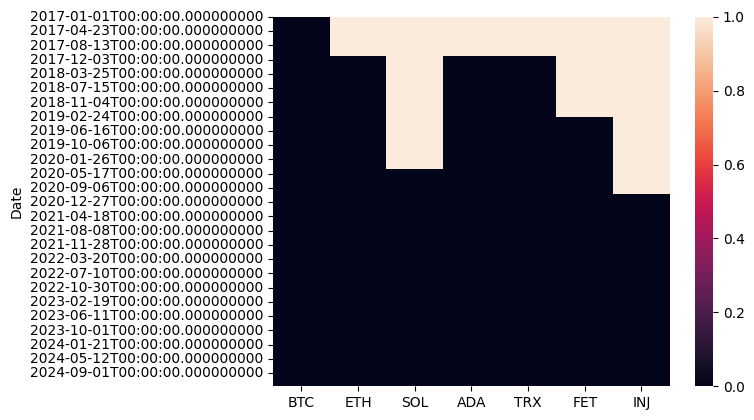

In [6]:
sns.heatmap(cryptos_df.isnull())

In [7]:
#apaga registros nulos
cryptos_df.dropna(inplace=True)
cryptos_df.to_csv('acoes.csv')
cryptos_df

BTC          ETH         SOL       ADA       TRX  \
Date                                                                     
2020-10-21   12823.689453   392.189972    1.890378  0.106187  0.026721   
2020-10-22   12965.891602   413.772980    1.955653  0.110572  0.027042   
2020-10-23   12931.539062   409.766693    1.960035  0.108083  0.026691   
2020-10-24   13108.062500   412.457611    1.911828  0.108075  0.027050   
2020-10-25   13031.173828   406.217773    1.787459  0.106351  0.026935   
...                   ...          ...         ...       ...       ...   
2024-12-08  101236.015625  4005.704590  236.672333  1.196291  0.318823   
2024-12-09   97432.718750  3718.690430  217.341461  1.007549  0.263300   
2024-12-10   96675.429688  3631.833740  213.824615  1.020161  0.269958   
2024-12-11  101173.031250  3832.822021  227.446838  1.088890  0.282482   
2024-12-13   99394.203125  3888.881592  226.557205  1.108691  0.295247   

                 FET        INJ  
Date                             
2020-10-21  0.045765   0.773266  
2020-10-22  0.049113   0.789443  
2020-10-23  0.053041   1.183961  
2020-10-24  0.056407   0.965414  
2020-10-25  0.051211   0.901291  
...              ...        ...  
2024-12-08  2.060343  33.193150  
2024-12-09  1.716155  28.135157  
2024-12-10  1.684594  27.128040  
2024-12-11  1.819680  28.845022  
2024-12-13  1.790713  28.892784  

[1514 rows x 7 columns]

### Visualização dos dados 

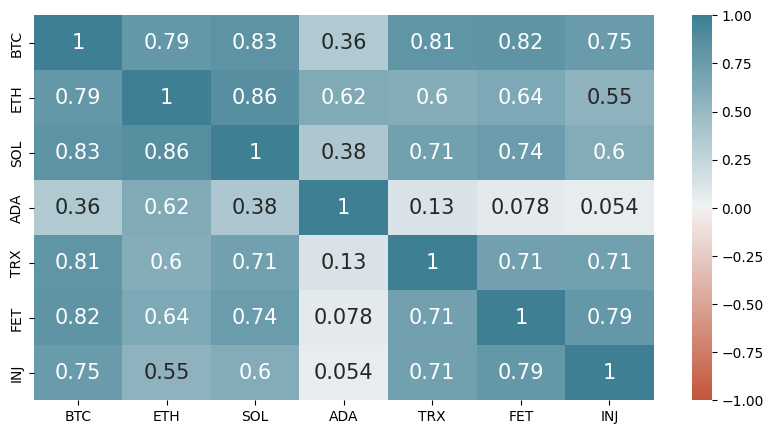

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=cryptos_df.columns
corrmat = cryptos_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [9]:
cryptos_df.iloc[0].values

array([1.28236895e+04, 3.92189972e+02, 1.89037800e+00, 1.06187001e-01,
       2.67210007e-02, 4.57650013e-02, 7.73266017e-01])

In [10]:
# Normaliza os dados
cryptos_df_normalized = cryptos_df / cryptos_df.iloc[0].values

In [11]:
cryptos_df_normalized

BTC        ETH         SOL        ADA        TRX        FET  \
Date                                                                           
2020-10-21  1.000000   1.000000    1.000000   1.000000   1.000000   1.000000   
2020-10-22  1.011089   1.055032    1.034530   1.041295   1.012013   1.073156   
2020-10-23  1.008410   1.044817    1.036848   1.017855   0.998877   1.158986   
2020-10-24  1.022176   1.051678    1.011347   1.017780   1.012312   1.232536   
2020-10-25  1.016180   1.035768    0.945556   1.001544   1.008009   1.118999   
...              ...        ...         ...        ...        ...        ...   
2024-12-08  7.894453  10.213684  125.198417  11.265889  11.931552  45.020058   
2024-12-09  7.597869   9.481860  114.972488   9.488441   9.853673  37.499290   
2024-12-10  7.538816   9.260394  113.112095   9.607212  10.102840  36.809658   
2024-12-11  7.889542   9.772871  120.318179  10.254456  10.571535  39.761388   
2024-12-13  7.750827   9.915811  119.847568  10.440931  11.049251  39.128429   

                  INJ  
Date                   
2020-10-21   1.000000  
2020-10-22   1.020920  
2020-10-23   1.531117  
2020-10-24   1.248489  
2020-10-25   1.165564  
...               ...  
2024-12-08  42.925913  
2024-12-09  36.384835  
2024-12-10  35.082416  
2024-12-11  37.302845  
2024-12-13  37.364611  

[1514 rows x 7 columns]

In [12]:
#%% Carregando dados
cryptos_df=pd.read_csv('acoes.csv')
cryptos_df['Date']=pd.to_datetime(cryptos_df['Date'])
cryptos_df=cryptos_df.set_index('Date')
for col in cryptos_df.columns:
    cryptos_df[col]=cryptos_df[col].astype('float32')

In [13]:
cryptos_df_normalized = cryptos_df / cryptos_df.iloc[0].values

In [14]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for cryptos in cryptos_df.columns:
#fig.add_trace(go.Scatter(x=cryptos_df.index, y=cryptos_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=cryptos_df.index, y=cryptos_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=cryptos_df_normalized.index, y=cryptos_df_normalized[cryptos], mode='lines', name=f'Preço do {cryptos}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [15]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data 
import datetime
import plotly.graph_objects as go

# Define o código de ticker da crypto
ticker = "BTC"


ticker=ticker+"-USD"

# Obtém os dados históricos da crypto
df = data.DataReader(ticker, start='2013-01-01')


[*********************100%%**********************]  1 of 1 completed


In [16]:
df.iloc[-10:,:]

Open           High           Low          Close  \
Date                                                                    
2024-12-03   95854.593750   96297.203125  93629.562500   96002.164062   
2024-12-04   95988.531250   99207.328125  94660.523438   98768.531250   
2024-12-05   98741.539062  103900.468750  91998.781250   96593.570312   
2024-12-06   97074.226562  102039.882812  96514.875000   99920.710938   
2024-12-07   99916.710938  100563.382812  99030.882812   99923.335938   
2024-12-08   99921.914062  101399.992188  98771.515625  101236.015625   
2024-12-09  101237.062500  101272.507812  94355.914062   97432.718750   
2024-12-10   97441.234375   98270.156250  94321.257812   96675.429688   
2024-12-11   96656.062500  101913.359375  95747.226562  101173.031250   
2024-12-13  100030.851562  100308.367188  99337.585938   99394.203125   

                Adj Close        Volume  
Date                                     
2024-12-03   96002.164062   67067810961  
2024-12-04   98768.531250   77199817112  
2024-12-05   96593.570312  149218945580  
2024-12-06   99920.710938   94534772658  
2024-12-07   99923.335938   44177510897  
2024-12-08  101236.015625   44125751925  
2024-12-09   97432.718750  110676473908  
2024-12-10   96675.429688  104823780634  
2024-12-11  101173.031250   85391409936  
2024-12-13   99394.203125   71291043840

In [17]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)b
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111'] = df['Close'].rolling(window=111).mean()
df['MA350'] = df['Close'].rolling(window=350).mean() 
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [18]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111'], mode='lines', name='MA111'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350'], mode='lines', name='MA350'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [19]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [20]:
def labelling_method(close_price_list, window_days=11):
    window_size = window_days  # Tamanho da janela deslizante
    number_of_days = len(close_price_list)  # Total de dias no arquivo
    labels = []  # Lista para armazenar os rótulos
    
    for counter_row in range(number_of_days):
        if counter_row >= window_size:
            # Define os índices da janela
            window_begin_index = counter_row - window_size
            window_end_index = counter_row - 1
            window_middle_index = (window_begin_index + window_end_index) // 2

            # Inicializa variáveis de máximo e mínimo
            min_price = float('inf')
            max_price = float('-inf')
            min_index = -1
            max_index = -1

            # Percorre a janela para identificar máximos e mínimos
            for i in range(window_begin_index, window_end_index + 1):
                price = close_price_list[i]
                if price < min_price:
                    min_price = price
                    min_index = i
                if price > max_price:
                    max_price = price
                    max_index = i

            # Rotula o dia central
            if max_index == window_middle_index:
                labels.append("SELL")
            elif min_index == window_middle_index:
                labels.append("BUY")
            else:
                labels.append("HOLD")
        else:
            # Não é possível rotular dias antes de preencher a janela
            labels.append('HOLD')

    return labels

def label_data(data, window=10, buy_threshold=0.10, sell_threshold=-0.10):
    labels = []  # Store labels

    for i in range(len(data)):
        if i + window >= len(data):  # If the window exceeds data length
            labels.append("HOLD")
            continue

        current_price = data[i]
        future_prices = data[i+1:i+1+window]
        returns = (future_prices - current_price) / current_price

        if max(returns) >= buy_threshold:
            labels.append("BUY")
        elif min(returns) <= sell_threshold:
            labels.append("SELL")
        else:
            labels.append("HOLD")
    
    return labels

def backtest(close_price_list, labels, initial_capital=10000):
    cash = initial_capital  # Dinheiro em caixa
    shares = 0  # Quantidade de ações
    portfolio_values = []  # Histórico do valor total do portfólio
    
    for i, label in enumerate(labels):
        price = close_price_list[i]
        
        if label == "BUY" and cash >= price:
            # Compra ações com todo o capital disponível
            shares_to_buy = cash // price
            shares += shares_to_buy
            cash -= shares_to_buy * price
            #print(f"BUY: Comprado {shares_to_buy} ações a R$ {price:.2f}")
        
        elif label == "SELL" and shares > 0:
            # Vende todas as ações
            cash += shares * price
            #print(f"SELL: Vendido {shares} ações a R$ {price:.2f}")
            shares = 0

        # Valor atual do portfólio
        portfolio_value = cash + shares * price
        portfolio_values.append(portfolio_value)
    
    # Resultado final
    final_value = cash + shares * close_price_list[-1]
    #print(f"Valor final do portfólio: R$ {final_value:.2f}")
    #print(f"Retorno total: {((final_value - initial_capital) / initial_capital) * 100:.2f}%")

    return portfolio_values

In [21]:


# Dados de exemplo
close_price_list = df['Close'].values

#labels = labelling_method(close_price_list, 60)
labels = label_data(df['Close'], window=7, buy_threshold=0.05, sell_threshold=-0.05)
print(np.unique(labels, return_counts=True))
# Realizar o backtest
portfolio_values = backtest(close_price_list, labels, initial_capital=100)

# Gráfico do desempenho
import plotly.graph_objects as go

#fig = go.Figure()

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Preço da ação
#fig.add_trace(go.Scatter(
#    x=df.index,
#    y=close_price_list,
#    mode='lines',
#    name='Preço da Ação'
#))

# Valor do portfólio
fig.add_trace(go.Scatter(
    x=df.index,
    y=portfolio_values,
    mode='lines',
    name='Valor do Portfólio'
))

# Configuração do layout
fig.update_layout(
    title="Backtest de Estratégia de BUY, SELL, HOLD",
    xaxis_title="Data",
    yaxis_title="Valor",
    #showlegend=True
)


# Adiciona os marcadores BUY, SELL e HOLD
for i, label in enumerate(labels):
    if label == "BUY":
        fig.add_trace(go.Scatter(
            x=[df.index[i]],
            y=[df['Close'].iloc[i]],
            mode='markers',
            marker=dict(color='green', size=10, symbol='triangle-up'),
            name='BUY'
        ))
    elif label == "SELL":
        fig.add_trace(go.Scatter(
            x=[df.index[i]],
            y=[df['Close'].iloc[i]],
            mode='markers',
            marker=dict(color='yellow', size=10, symbol='triangle-down'),
            name='SELL'
        ))
fig.show()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\1048875421.py:50: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



(array(['BUY', 'HOLD', 'SELL'], dtype='<U4'), array([1495, 1258,  987], dtype=int64))


In [22]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


Date           Open           High           Low          Close  \
0    2014-09-17     465.864014     468.174011    452.421997     457.334015   
1    2014-09-18     456.859985     456.859985    413.104004     424.440002   
2    2014-09-19     424.102997     427.834991    384.532013     394.795990   
3    2014-09-20     394.673004     423.295990    389.882996     408.903992   
4    2014-09-21     408.084991     412.425995    393.181000     398.821014   
...         ...            ...            ...           ...            ...   
3735 2024-12-08   99921.914062  101399.992188  98771.515625  101236.015625   
3736 2024-12-09  101237.062500  101272.507812  94355.914062   97432.718750   
3737 2024-12-10   97441.234375   98270.156250  94321.257812   96675.429688   
3738 2024-12-11   96656.062500  101913.359375  95747.226562  101173.031250   
3739 2024-12-13  100030.851562  100308.367188  99337.585938   99394.203125   

          Adj Close        Volume  upper_band_bollinger  lower_band_bollinger  \
0        457.334015      21056800              0.000000              0.000000   
1        424.440002      34483200              0.000000              0.000000   
2        394.795990      37919700              0.000000              0.000000   
3        408.903992      36863600              0.000000              0.000000   
4        398.821014      26580100              0.000000              0.000000   
...             ...           ...                   ...                   ...   
3735  101236.015625   44125751925         101842.292027          91775.647035   
3736   97432.718750  110676473908         101640.118094          92486.713937   
3737   96675.429688  104823780634         101580.031099          92780.394682   
3738  101173.031250   85391409936         102032.786631          92594.469619   
3739   99394.203125   71291043840         102085.620765          92581.289392   

              EMA9  ...        MA350*2     RSI_14         MACD       Signal  \
0       457.334015  ...       0.000000   0.000000     0.000000     0.000000   
1       439.059564  ...       0.000000   0.000000    -2.624024    -0.524805   
2       420.918755  ...       0.000000   0.000000    -7.014744    -1.822793   
3       416.848713  ...       0.000000   0.000000    -9.249402    -3.308115   
4       411.485880  ...       0.000000   0.000000   -11.699137    -4.986319   
...            ...  ...            ...        ...          ...          ...   
3735  98412.582126  ...  126754.056518  56.417911  4134.980313  4518.090908   
3736  98216.609451  ...  127061.596964  59.023622  3807.286750  4375.930077   
3737  97908.373498  ...  127371.054263  59.921859  3446.748371  4190.093736   
3738  98561.305049  ...  127700.940982  60.785273  3483.779130  4048.830814   
3739  98727.884664  ...  128025.320112  57.301119  3331.189827  3905.302617   

      Variation  Classification  weekday  day  month  quarter  
0      0.000000               0        3   17      9        3  
1     -7.749979              -1        4   18      9        3  
2     -7.508691              -1        5   19      9        3  
3      3.450199               1        6   20      9        3  
4     -2.528196              -1        7   21      9        3  
...         ...             ...      ...  ...    ...      ...  
3735   1.296653               1        7    8     12        4  
3736  -3.903511              -1        1    9     12        4  
3737  -0.783331              -1        2   10     12        4  
3738   4.445455               1        3   11     12        4  
3739  -1.789670              -1        5   13     12        4  

[3740 rows x 27 columns]

## Data preprocessing to stock forecast

In [23]:
del acao, axes, close_price_list, col, columns, corrmat, cryptos, cryptos_df, cryptos_df_normalized, df, fig, 

In [24]:
import requests
import pandas as pd
import numpy as np

# Lista de criptomoedas
cryptos = ['BTC']
peso_cryptos = np.ones(len(cryptos)) * 1 / len(cryptos)

# Adiciona o par USD para cada cripto
cryptos = [crypto + "USDT" for crypto in cryptos]

# Função para baixar dados históricos da Binance API
def get_binance_data(symbol, interval='1d', start_time='2017-01-01'):
    base_url = "https://api.binance.com/api/v3/klines"
    end_time = int(pd.Timestamp.now().timestamp() * 1000)  # Data atual

    # Converte a data de início para timestamp
    start_timestamp = int(pd.Timestamp(start_time).timestamp() * 1000)

    # Lista para armazenar os dados
    data_list = []

    # Faça requisições iterativas até obter todos os dados
    while start_timestamp < end_time:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_timestamp,
            'endTime': start_timestamp + (1000 * 60 * 60 * 24 * 365),  # Intervalo de 1 ano
            'limit': 1000  # Máximo de registros por chamada
        }

        # Coleta dados da API
        response = requests.get(base_url, params=params)
        data = response.json()

        # Verifica se a resposta da API está vazia
        if not data:
            break

        # Converte os dados em DataFrame
        df = pd.DataFrame(data, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base', 'taker_buy_quote', 'ignore'
        ])

        # Verifica se o DataFrame está vazio
        if df.empty:
            break

        # Adiciona os dados à lista
        data_list.append(df)

        # Atualiza o start_timestamp para a próxima requisição
        if not df.empty:
            start_timestamp = int(df['timestamp'].iloc[-1]) + 1000  # Adiciona 1 segundo ao último timestamp
        else:
            break

    # Concatena todos os DataFrames
    if data_list:
        df = pd.concat(data_list, ignore_index=True)
    else:
        df = pd.DataFrame()

    # Formata e filtra os dados necessários
    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df['close'] = df['close'].astype(float)
        df['low'] = df['low'].astype(float)
        df['high'] = df['high'].astype(float)
        df['open'] = df['open'].astype(float)
        df['volume'] = df['volume'].astype(float)
    return df


# Intervalos disponíveis
intervals = ['1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h', '1d', '3d', '1w', '1M']

#choice = int(input("Escolha um intervalo (número): "))
#interval = intervals[choice - 1]
interval ='4h'

# Baixar e consolidar dados em um DataFrame
cryptos_df = pd.DataFrame()
for crypto in cryptos:
    data = get_binance_data(crypto, start_time='2017-01-01', interval=interval)
    # Ajusta o nome da coluna removendo "USDT" antes de adicionar ao DF
    #data.columns = [crypto.replace('USDT', '')]
    if cryptos_df.empty:
        cryptos_df = data
    else:
        cryptos_df = pd.concat([cryptos_df, data], axis=1)

if not cryptos_df.empty:
    cryptos_df = cryptos_df.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume',
    })
    # Visualização dos dados
    cryptos_df=cryptos_df.rename_axis('Date')
    print(cryptos_df.shape)
else:
    print("Nenhum dado encontrado para o símbolo e intervalo especificados.")

df=cryptos_df

(16034, 11)


In [25]:
df.reset_index(inplace = True)


### Pré-processamento dos dados para predição 

In [26]:
class ComputIdicators():
     def __init__(self):
          pass
     def autorregressive_coefs(self,data,p=3):
        channels=data.shape(self.axis) 

        phi=np.zeros([data.shape[0],data.shape[1],p])

        ar_coefs=np.zeros([channels,p])

        y_init=[]

        y = data

        aux=np.zeros(p)
        for k in range(p): 
            aux[p-k:]=y[:k]
            y_init.append(aux.copy())

        phi=np.vstack([y[i-p:i] if i-p>=0 else y_init[i]  for i in range(0, len(y))])

        ar_coefs[:]=np.linalg.inv(phi[:].T.dot(phi[:])).dot(phi[:].T.dot(data[:]))
            
        return ar_coefs
     
     def moving_average(self,data, window_length):
          """
          Calculates the Moving Average (MA) of a time series data.

          Args:
               data: A list or NumPy array containing the time series data.
               window_length: The number of periods to use for the MA calculation (window size).

          Returns:
               A NumPy array containing the MA values for each data point.
          """

          if window_length < 1:
               raise ValueError("Window length must be a positive integer.")

          # Initialize empty array for MA values
          moving_average_values = np.zeros(len(data))

          # Iterate through the data
          for i in range(len(data)):
               # Check if the window goes beyond the data boundary
               if i < window_length - 1:
                    # If within the initial window, use the average of available data points
                    moving_average_values[i] = np.mean(data[:i+1])
               else:
                    # For other points, use the average of the window
                    window_slice = data[i - window_length + 1 : i + 1]
                    moving_average_values[i] = np.mean(window_slice)

          return moving_average_values
     def exponential_moving_average(self, data, window_length):
          """
          Calculates the Exponential Moving Average (EMA) of a time series data.

          Args:
               data: A list or NumPy array containing the time series data.
               window_length: The number of periods to use for the EMA calculation.

          Returns:
               A NumPy array containing the EMA values for each data point.
          """

          if window_length < 1:
               raise ValueError("Window length must be a positive integer.")

          ema = np.zeros(len(data))
          # Handle the initial EMA calculation (use simple average for the first window_length elements)
          ema[:window_length] = np.mean(data[:window_length])
          alpha = 2 / (1 + window_length)  # Smoothing factor (weight for the current data point)

          for i in range(window_length, len(data)):
               ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
          
          return ema

     def macd(self,data, fast_period=12, slow_period=26, signal_period=9):
          """
          Calculates the MACD (Moving Average Convergence Divergence) indicator for a time series data.

          Args:
               data: A list or NumPy array containing the closing price data.
               fast_period: The number of periods for the fast Exponential Moving Average (EMA). (default: 12)
               slow_period: The number of periods for the slow Exponential Moving Average (EMA). (default: 26)
               signal_period: The number of periods for the EMA of the MACD difference. (default: 9)

          Returns:
               A tuple containing three NumPy arrays:
                    - macd: The MACD line (fast EMA minus slow EMA)
                    - macd_signal: The signal line (EMA of the MACD difference)
                    - macd_histogram: The MACD histogram (MACD minus signal line)
          """

          # Check if window lengths are positive integers
          if any(period < 1 for period in [fast_period, slow_period, signal_period]):
               raise ValueError("Window lengths must be positive integers.")

          # Calculate the fast EMA and slow EMA
          ema_fast = self.exponential_moving_average(data, fast_period)
          ema_slow = self.exponential_moving_average(data, slow_period)

          # Calculate the MACD line (fast EMA minus slow EMA)
          macd = ema_fast - ema_slow

          # Calculate the MACD signal line (EMA of the MACD difference)
          macd_signal = self.exponential_moving_average(macd, signal_period)

          # Calculate the MACD histogram (MACD minus signal line)
          macd_histogram = macd - macd_signal

          return macd, macd_signal, macd_histogram

     def rsi(self, data, period=14, pred_days = 1):
          if period < 1:
               raise ValueError("Period must be a positive integer.")

          delta=self.get_variations(data, days_lookback = pred_days)
          # Calcular as diferenças dos preços
          #delta = np.diff(data)

               # Separar os ganhos e perdas
          up_changes = np.where(delta > 0, delta, 0)
          down_changes = np.where(delta < 0, np.abs(delta), 0)

          # Calcular a média dos ganhos e perdas
          avg_gain = np.zeros(len(up_changes))
          avg_loss = np.zeros(len(down_changes))

          # Calcular a média para os primeiros 'period' dados
          avg_gain[:period] = np.cumsum(up_changes[:period]) / np.arange(1, period + 1)
          avg_loss[:period] = np.cumsum(down_changes[:period]) / np.arange(1, period + 1)

          # Calcular a média para o resto dos dados
          for i in range(period, len(up_changes)):
               avg_gain[i] = (avg_gain[i - 1] * (period - 1) + up_changes[i]) / period
               avg_loss[i] = (avg_loss[i - 1] * (period - 1) + down_changes[i]) / period

          # Calcular o Relative Strength (RS)
          rs = avg_gain / avg_loss
          rs = np.where(avg_loss == 0, np.inf, rs)

          # Calcular o RSI
          rsi = 100 - (100 / (1 + rs))

          # Retornar os valores de RSI, começando do período especificado
          #print('data',data.shape)
          return np.array(np.zeros(period - 1).tolist() + rsi[period - 1:].tolist())


     def cci(self, high_prices, low_prices, close_prices, window_length=20):
          """
          Calculates the Commodity Channel Index (CCI) indicator for a time series data.

          Args:
               high_prices: A list or NumPy array containing the high prices.
               low_prices: A list or NumPy array containing the low prices.
               close_prices: A list or NumPy array containing the closing prices.
               window_length: The number of periods to use for the calculation. (default: 20)

          Returns:
               A NumPy array containing the CCI values for each data point.
          """
          typical_prices = (high_prices + low_prices + close_prices) / 3
          sma_typical_prices = self.moving_average(typical_prices, window_length=window_length)
          mean_deviation = np.mean(np.abs(typical_prices - sma_typical_prices))
          cci_values = (typical_prices - sma_typical_prices) / (0.015 * mean_deviation)
          
          return cci_values
     def stochastic(self, high_prices, low_prices, close_prices, window_length=14, smooth_k=3, smooth_d=3):
          """
          Calculates the Stochastic Oscillator indicator for a time series data.

          Args:
               high_prices: A list or NumPy array containing the high prices.
               low_prices: A list or NumPy array containing the low prices.
               close_prices: A list or NumPy array containing the closing prices.
               window_length: The number of periods to use for the calculation. (default: 14)
               smooth_k: The number of periods for smoothing %K line. (default: 3)
               smooth_d: The number of periods for smoothing %D line. (default: 3)

          Returns:
               A tuple containing two NumPy arrays:
                    - percent_k: The %K line.
                    - percent_d: The %D line.
          """

          if window_length < 1 or smooth_k < 1 or smooth_d < 1:
               raise ValueError("Window lengths must be positive integers.")

          # Calculate %K
          lowest_low = self.minimum(low_prices, window_length)
          highest_high = self.maximum(high_prices, window_length)
          percent_k = 100 * ((close_prices - lowest_low) / (highest_high - lowest_low))

          # Smooth %K to get %D
          percent_d = self.moving_average(percent_k, window_length=smooth_k)

          return percent_k, percent_d
     
     def bollinger_bands(self, data, window_length=20, num_std=2):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        moving_average = self.moving_average(data, window_length)
        std_deviation = np.zeros(len(data))
        for i in range(len(data)):
            if i < window_length - 1:
                std_deviation[i] = np.std(data[:i+1])
            else:
                std_deviation[i] = np.std(data[i - window_length + 1: i + 1])
        upper_band = moving_average + num_std * std_deviation
        lower_band = moving_average - num_std * std_deviation

        return moving_average, upper_band, lower_band
     import numpy as np

class ComputIndicators():
    def __init__(self):
        pass

    def autorregressive_coefs(self, data, p=3):
        channels = data.shape[0]
        phi = np.zeros([data.shape[0], p])
        ar_coefs = np.zeros([channels, p])
        y_init = []
        y = data
        aux = np.zeros(p)
        for k in range(p): 
            aux[p-k:] = y[k]
            y_init.append(aux.copy())
        phi = np.vstack([y[i-p:i] if i-p>=0 else y_init[i]  for i in range(0, len(y))])
        ar_coefs[:] = np.linalg.inv(phi.T.dot(phi)).dot(phi.T.dot(data))
        return ar_coefs

    def moving_average(self, data, window_length):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        moving_average_values = np.zeros(len(data))
        for i in range(len(data)):
            if i < window_length - 1:
                moving_average_values[i] = np.mean(data[:i+1])
            else:
                window_slice = data[i - window_length + 1 : i + 1]
                moving_average_values[i] = np.mean(window_slice)
        return moving_average_values

    def exponential_moving_average(self, data, window_length):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        ema = np.zeros(len(data))
        ema[:window_length] = np.mean(data[:window_length])
        alpha = 2 / (1 + window_length)  
        for i in range(window_length, len(data)):
            ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
        return ema

    def macd(self, data, fast_period=12, slow_period=26, signal_period=9):
        if any(period < 1 for period in [fast_period, slow_period, signal_period]):
            raise ValueError("Window lengths must be positive integers.")
        ema_fast = self.exponential_moving_average(data, fast_period)
        ema_slow = self.exponential_moving_average(data, slow_period)
        macd = ema_fast - ema_slow
        macd_signal = self.exponential_moving_average(macd, signal_period)
        macd_histogram = macd - macd_signal
        return macd, macd_signal, macd_histogram

    def rsi(self, data, period=14, pred_days = 1):
        if period < 1:
            raise ValueError("Period must be a positive integer.")
        delta = np.diff(data)
        up_changes = np.where(delta > 0, delta, 0)
        down_changes = np.where(delta < 0, np.abs(delta), 0)
        avg_gain = np.zeros(len(data))
        avg_loss = np.zeros(len(data))
        avg_gain[:period] = np.cumsum(up_changes[:period]) / np.arange(1, period + 1)
        avg_loss[:period] = np.cumsum(down_changes[:period]) / np.arange(1, period + 1)
        for i in range(period, len(up_changes)):
            avg_gain[i + 1] = (avg_gain[i] * (period - 1) + up_changes[i]) / period
            avg_loss[i + 1] = (avg_loss[i] * (period - 1) + down_changes[i]) / period
        rs = avg_gain / avg_loss
        rs = np.where(avg_loss == 0, np.inf, rs)
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def cci(self, high_prices, low_prices, close_prices, window_length=20):
        typical_prices = (high_prices + low_prices + close_prices) / 3
        sma_typical_prices = self.moving_average(typical_prices, window_length)
        mean_deviation = np.mean(np.abs(typical_prices - sma_typical_prices))
        cci_values = (typical_prices - sma_typical_prices) / (0.015 * mean_deviation)
        return cci_values

    def stochastic(self, high_prices, low_prices, close_prices, window_length=14, smooth_k=3, smooth_d=3):
        if window_length < 1 or smooth_k < 1 or smooth_d < 1:
            raise ValueError("Window lengths must be positive integers.")
        lowest_low = self.minimum(low_prices, window_length)
        highest_high = self.maximum(high_prices, window_length)
        percent_k = 100 * ((close_prices - lowest_low) / (highest_high - lowest_low))
        percent_d = self.moving_average(percent_k, window_length=smooth_k)
        return percent_k, percent_d

    def bollinger_bands(self, data, window_length=20, num_std=2):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        moving_average = self.moving_average(data, window_length)
        std_deviation = np.zeros(len(data))
        for i in range(len(data)):
            if i < window_length - 1:
                std_deviation[i] = np.std(data[:i+1])
            else:
                std_deviation[i] = np.std(data[i - window_length + 1: i + 1])
        upper_band = moving_average + num_std * std_deviation
        lower_band = moving_average - num_std * std_deviation
        return moving_average, upper_band, lower_band

    def minimum(self, data, window_length):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        minimum_values = np.zeros(len(data))
        for i in range(len(data)):
            if i < window_length - 1:
                minimum_values[i] = np.min(data[:i+1])
            else:
                window_slice = data[i - window_length + 1: i + 1]
                minimum_values[i] = np.min(window_slice)
        return minimum_values

    def maximum(self, data, window_length):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        maximum_values = np.zeros(len(data))
        for i in range(len(data)):
            if i < window_length - 1:
                maximum_values[i] = np.max(data[:i+1])
            else:
                window_slice = data[i - window_length + 1: i + 1]
                maximum_values[i] = np.max(window_slice)
        return maximum_values

    def momentum(self, data, window_length=10):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        momentum_values = np.zeros(len(data))
        for i in range(len(data)):
            if i < window_length - 1:
                momentum_values[i] = data[i]
            else:
                momentum_values[i] = data[i] - data[i - window_length]
        return momentum_values

    def roc(self, data, window_length=10):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        roc_values = np.zeros(len(data))
        for i in range(len(data)):
            if i < window_length - 1:
                roc_values[i] = 0
            else:
                roc_values[i] = (data[i] - data[i - window_length]) / data[i - window_length] * 100
        return roc_values

    def on_balance_volume(self, close_prices, volumes):
        if len(close_prices) != len(volumes):
            raise ValueError("The lengths of close prices and volumes must be equal.")
        obv = np.zeros(len(close_prices))
        obv[0] = volumes[0]
        for i in range(1, len(close_prices)):
            if close_prices[i] > close_prices[i - 1]:
                obv[i] = obv[i - 1] + volumes[i]
            elif close_prices[i] < close_prices[i - 1]:
                obv[i] = obv[i - 1] - volumes[i]
            else:
                obv[i] = obv[i - 1]
        return obv

    def accumulation_distribution_line(self, high_prices, low_prices, close_prices, volumes):
        if len(high_prices) != len(low_prices) or len(high_prices) != len(close_prices) or len(high_prices) != len(volumes):
            raise ValueError("The lengths of all input arrays must be equal.")
        money_flow = np.zeros(len(high_prices))
        for i in range(len(high_prices)):
            money_flow[i] = ((high_prices[i] + low_prices[i] + close_prices[i]) / 3) * volumes[i]
        ad_line = np.zeros(len(high_prices))
        ad_line[0] = money_flow[0]
        for i in range(1, len(high_prices)):
            ad_line[i] = ad_line[i - 1] + money_flow[i]
        return ad_line

    def money_flow_index(self, high_prices, low_prices, close_prices, volumes, window_length=14):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        money_flow = np.zeros(len(high_prices))
        for i in range(len(high_prices)):
            money_flow[i] = ((high_prices[i] + low_prices[i] + close_prices[i]) / 3) * volumes[i]
        positive_flow = np.zeros(len(high_prices))
        negative_flow = np.zeros(len(high_prices))
        for i in range(len(high_prices)):
            if i < window_length - 1:
                positive_flow[i] = np.sum(money_flow[:i+1][money_flow[:i+1] > 0])
                negative_flow[i] = np.sum(money_flow[:i+1][money_flow[:i+1] < 0])
            else:
                window_slice = money_flow[i - window_length + 1: i + 1]
                positive_flow[i] = np.sum(window_slice[window_slice > 0])
                negative_flow[i] = np.sum(window_slice[window_slice < 0])
        mfi = 100 - (100 / (1 + positive_flow / np.abs(negative_flow)))
        return mfi

    def ichimoku_cloud(self, high_prices, low_prices, window_length1=9, window_length2=26, window_length3=52):
        if window_length1 < 1 or window_length2 < 1 or window_length3 < 1:
            raise ValueError("Window lengths must be positive integers.")
        Tenkan_sen = (self.maximum(high_prices, window_length1) + self.minimum(low_prices, window_length1)) / 2
        Kijun_sen = (self.maximum(high_prices, window_length2) + self.minimum(low_prices, window_length2)) / 2
        Senkou_span_a = (Tenkan_sen + Kijun_sen) / 2
        Senkou_span_b = (self.maximum(high_prices, window_length3) + self.minimum(low_prices, window_length3)) / 2
        return Tenkan_sen, Kijun_sen, Senkou_span_a, Senkou_span_b

    def parabolic_sar(self, high_prices, low_prices, acceleration=0.02, maximum=0.2):
        if acceleration < 0 or maximum < 0:
            raise ValueError("Acceleration and maximum must be non-negative.")
        sar = np.zeros(len(high_prices))
        sar[0] = low_prices[0]
        direction = 1
        for i in range(1, len(high_prices)):
            if direction == 1:
                sar[i] = sar[i - 1] + acceleration * (high_prices[i - 1] - sar[i - 1])
                if low_prices[i] < sar[i]:
                    direction = -1
                    sar[i] = low_prices[i]
            else:
                sar[i] = sar[i - 1] - acceleration * (low_prices[i - 1] - sar[i - 1])
                if high_prices[i] > sar[i]:
                    direction = 1
                    sar[i] = high_prices[i]
            if acceleration > maximum:
                acceleration = maximum
        return sar

    def average_directional_index(self, high_prices, low_prices, close_prices, window_length=14):
        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")
        plus_di = np.zeros(len(high_prices))
        minus_di = np.zeros(len(high_prices))
        for i in range(1, len(high_prices)):
            plus_dm = high_prices[i] - high_prices[i - 1]
            minus_dm = low_prices[i - 1] - low_prices[i]
            if plus_dm > minus_dm and plus_dm > 0:
                plus_di[i] = plus_dm
            if minus_dm > plus_dm and minus_dm > 0:
                minus_di[i] = minus_dm
        plus_di = self.moving_average(plus_di, window_length)
        minus_di = self.moving_average(minus_di, window_length)
        adx = 100 * (np.abs(plus_di - minus_di) / (plus_di + minus_di))
        return adx

    def fibonacci_retracements(self, high_price, low_price):
        if high_price < low_price:
            raise ValueError("High price must be greater than or equal to low price.")
        levels = [low_price, low_price + (high_price - low_price) * 0.236, low_price + (high_price - low_price) * 0.382, 
                  low_price + (high_price - low_price) * 0.5, low_price + (high_price - low_price) * 0.618, low_price + (high_price - low_price) * 0.764, high_price]
        return levels

    def candlestick_patterns(self, open_prices, high_prices, low_prices, close_prices):
        if len(open_prices) != len(high_prices) or len(open_prices) != len(low_prices) or len(open_prices) != len(close_prices):
            raise ValueError("The lengths of all input arrays must be equal.")
        patterns = []
        for i in range(len(open_prices)):
            if close_prices[i] > open_prices[i] and high_prices[i] > close_prices[i] and low_prices[i] < open_prices[i]:
                patterns.append(" Hammer")
            elif close_prices[i] < open_prices[i] and high_prices[i] > open_prices[i] and low_prices[i] < close_prices[i]:
                patterns.append("Shooting Star")
            # Add more patterns as needed
        return patterns

    def elliott_wave_theory(self, high_prices, low_prices):
        if len(high_prices) != len(low_prices):
            raise ValueError("The lengths of high prices and low prices must be equal.")
        waves = []
        for i in range(len(high_prices)):
            if high_prices[i] > high_prices[i - 1] and low_prices[i] > low_prices[i - 1]:
                waves.append("Impulse Wave")
            elif high_prices[i] < high_prices[i - 1] and low_prices[i] < low_prices[i - 1]:
                waves.append("Corrective Wave")
            # Add more wave patterns as needed
        return waves
     

In [27]:
# Criando uma instância da classe ComputIndicators
indicators = ComputIndicators()

# Calculando os indicadores técnicos
macd, macd_signal, macd_histogram = indicators.macd(df['Close'])
rsi = indicators.rsi(df['Close'])
cci = indicators.cci(df['High'], df['Low'], df['Close'])
k, d = indicators.stochastic(df['High'], df['Low'], df['Close'])
upper_bb, ma, lower_bb = indicators.bollinger_bands(df['Close'])

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

divide by zero encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

invalid value encountered in divide



In [28]:
df['Close'].shape

(16034,)

In [29]:
k, d = indicators.stochastic(df['High'], df['Low'], df['Close'])

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

divide by zero encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

invalid value encountered in divide



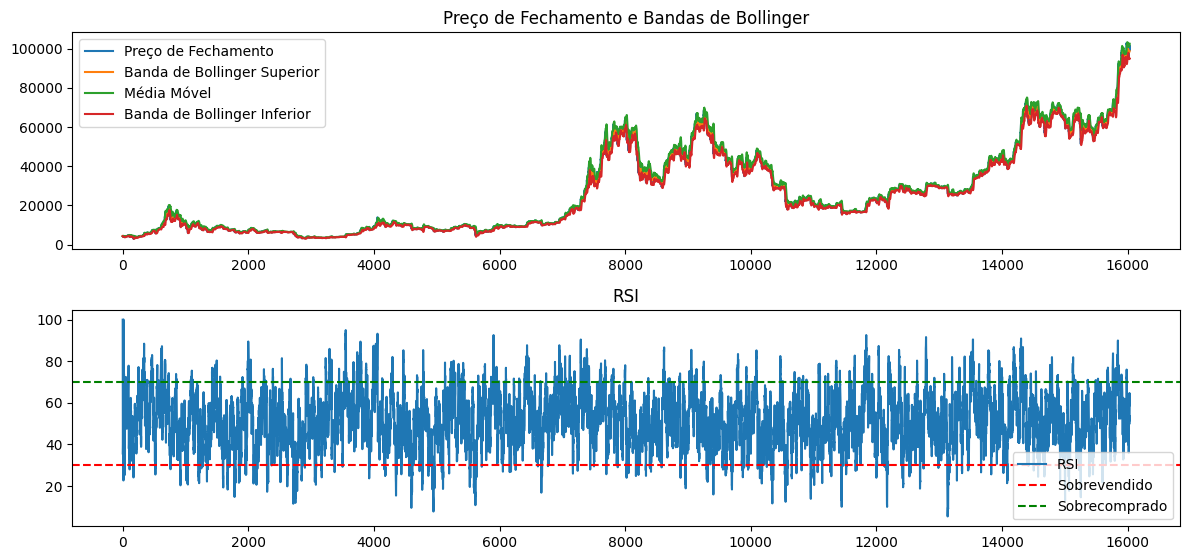

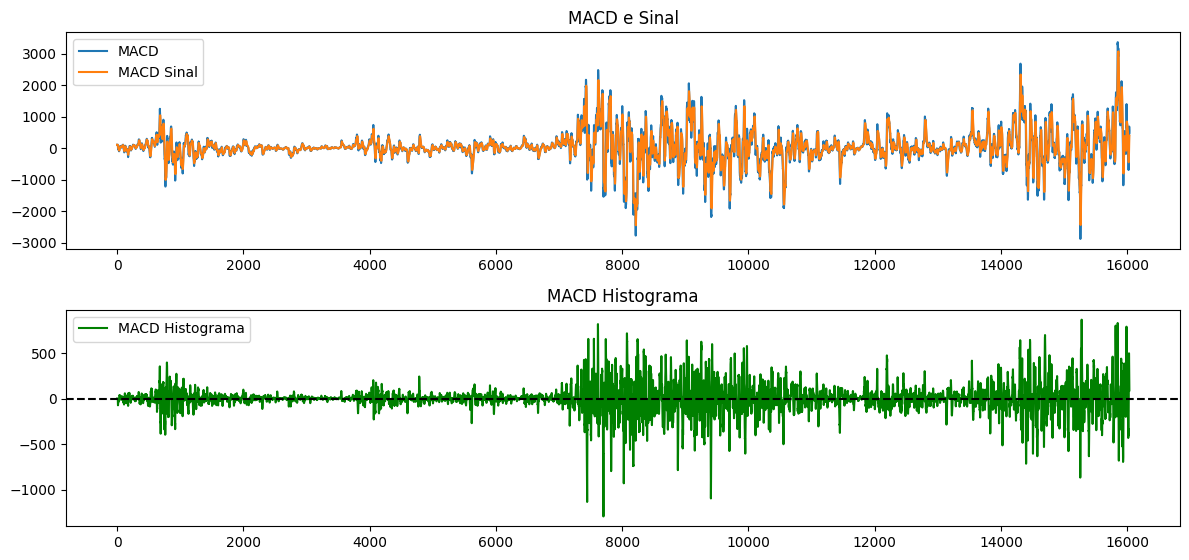

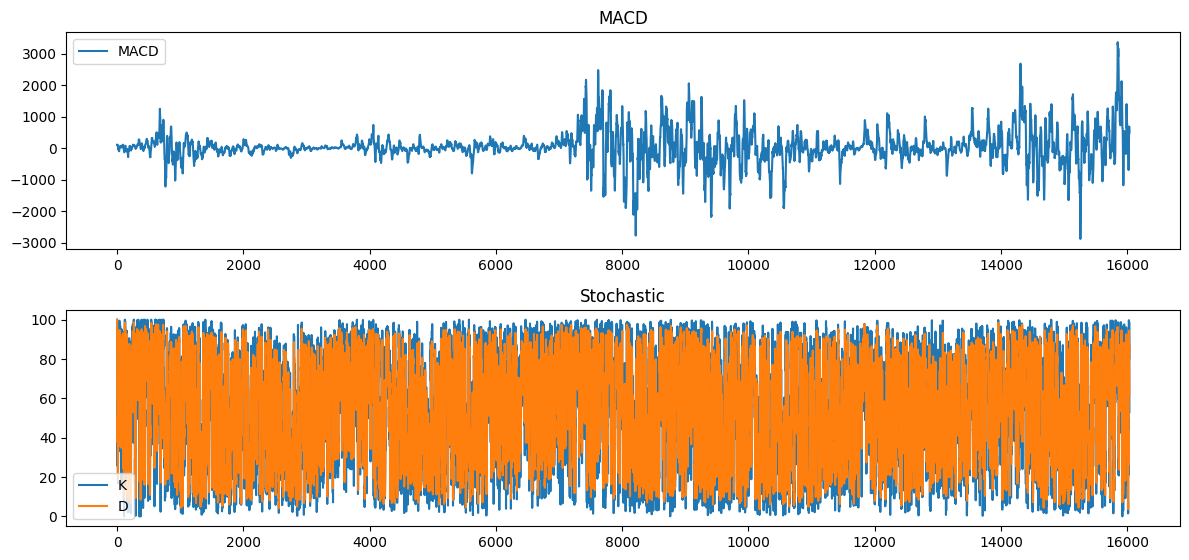

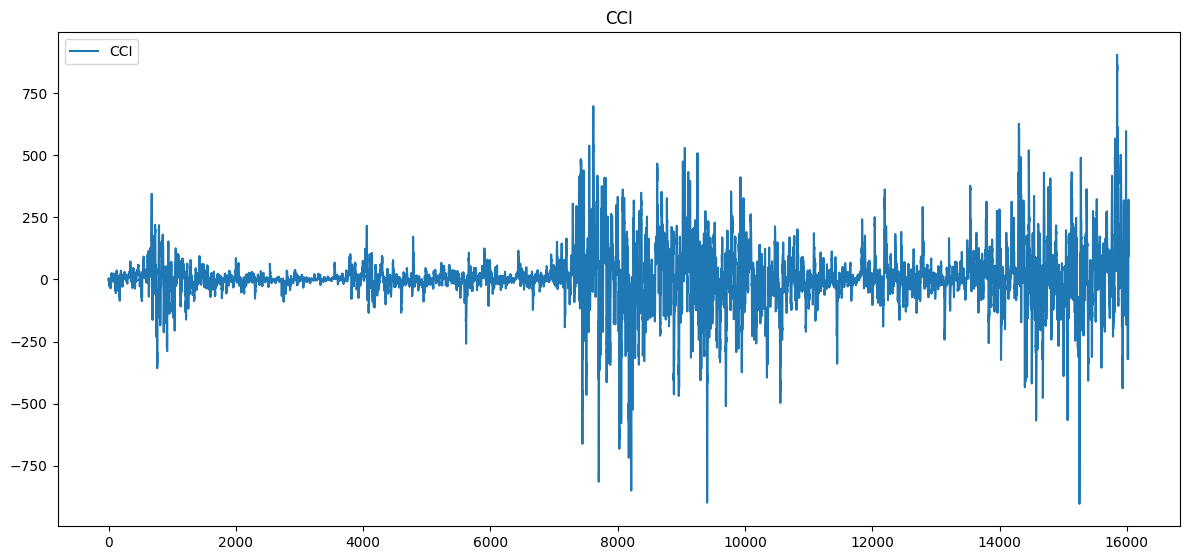

In [30]:
import matplotlib.pyplot as plt

# Criando uma instância da classe ComputIndicators
indicators = ComputIndicators()

# Calculando os indicadores técnicos
macd, macd_signal, macd_histogram = indicators.macd(df['Close'])
rsi = indicators.rsi(df['Close'])
cci = indicators.cci(df['High'], df['Low'], df['Close'])
k, d = indicators.stochastic(df['High'], df['Low'], df['Close'])
upper_bb, ma, lower_bb = indicators.bollinger_bands(df['Close'])

# Plotando os indicadores técnicos
plt.figure(figsize=(12, 6), dpi=100)

plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Preço de Fechamento')
plt.plot(upper_bb, label='Banda de Bollinger Superior')
plt.plot(ma, label='Média Móvel')
plt.plot(lower_bb, label='Banda de Bollinger Inferior')
plt.legend(loc='best')
plt.title('Preço de Fechamento e Bandas de Bollinger')

plt.subplot(2, 1, 2)
plt.plot(rsi, label='RSI')
plt.axhline(y=30, color='r', linestyle='--', label='Sobrevendido')
plt.axhline(y=70, color='g', linestyle='--', label='Sobrecomprado')
plt.legend(loc='best')
plt.title('RSI')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(12, 6), dpi=100)

plt.subplot(2, 1, 1)
plt.plot(macd, label='MACD')
plt.plot(macd_signal, label='MACD Sinal')
plt.legend(loc='best')
plt.title('MACD e Sinal')

plt.subplot(2, 1, 2)
plt.plot(macd_histogram, label='MACD Histograma', color='g')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend(loc='best')
plt.title('MACD Histograma')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(12, 6), dpi=100)

plt.subplot(2, 1, 1)
plt.plot(macd, label='MACD')
plt.legend(loc='best')
plt.title('MACD')

plt.subplot(2, 1, 2)
plt.plot(k, label='K')
plt.plot(d, label='D')
plt.legend(loc='best')
plt.title('Stochastic')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(12, 6), dpi=100)

plt.plot(cci, label='CCI')
plt.legend(loc='best')
plt.title('CCI')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [31]:
class DatasetProcessing():
     def __init__(self):
          super().__init__()

     def norm_minmax(self,x_data, minimum=0, maximum=1, axis=None):
        """Performs the normalization of the values in x_data

        Args:
            x_data (ndarray): 2D matrix
            y_data (any): y_data. Defaults to None.

        Returns:
            tuple[ndarray, any]: tuple with the normalized matrix in the first index
        """
        if axis == None:
            axis= self.axis
            
        samples_min = x_data.min(axis=axis,keepdims=True) + sys.float_info.epsilon
        samples_max = x_data.max(axis=axis,keepdims=True)
        x_data = (x_data - samples_min) * (maximum - minimum)
        x_data = (x_data / (samples_max - samples_min) ) + minimum
        
        return x_data
     def split_data(self, X : np.array , date_time : np.datetime64, factor=0.70):
          """Split the data in train validation or test

          Args:
               X (np.array): _description_
               y (np.array): _description_
               date_time (np.datetime64): _description_
               factor (float, optional): _description_. Defaults to 0.70.

          Returns:
               _type_: _description_
          """
          nits=round(len(X)*factor)

          X_train=X[:nits]

          nit_test= np.max(X_train.shape) -1
          X_test = X[nit_test:]

          T_train = date_time[:nits]
          T_test = date_time[nit_test:]
          
          return X_train,X_test, T_train, T_test

     def weighted_categorical_crossentropy(self,weights):
          """
          from https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
          A weighted version of keras.objectives.categorical_crossentropy
          
          Variables:
               weights: numpy array of shape (C,) where C is the number of classes
          
          Usage:
               weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
               loss = weighted_categorical_crossentropy(weights)
               model.compile(loss=loss,optimizer='adam')
          """
          
          #weights = K.variable(weights)
          weights = tf.Variable(weights, dtype=tf.float32)    
          def loss(y_true, y_pred):
               # scale predictions so that the class probas of each sample sum to 1
               #y_true_printed = tf.print("y_true =", y_true)
               #y_pred_printed = tf.print("y_pred =", y_pred)
               
               y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
               # clip to prevent NaN's and Inf's
               y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
               # calc
               loss = y_true * K.log(y_pred) * weights
               loss = -K.sum(loss, -1)
               return loss
          
          return loss

In [32]:
from tqdm import tqdm
import time
from keras.utils import Sequence
from keras import backend as K
from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import RandomOverSampler 

class FeaturesDataGenerator(DatasetProcessing, ComputIndicators, Sequence):

    def __init__(self, X_df = None, lookback=1, pred_days=1, axis=0, batch_size=32, shuffle=False, processing=None, selected_features= None, data_augmentation=False):
        """
        Args:
            Features dataset_generator: The dataset generator providing input and output data.
            axis (int): Axis for feature computation.
            processing: Optional data processing function.
            selected_features (list): List of features to compute. If None, compute all features.
        """
        super().__init__()

        if  isinstance(X_df, pd.DataFrame): 
            X_data = X_df
        else :
            X_df = pd.DataFrame(data=np.zeros([20,6]),columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
            X_data = X_df

        self.X_df = X_df
        self.InputData = X_data
        self.lookback = lookback
        self.pred_days= pred_days
        self.inputShape = X_data.shape
        #self.outputShape = dataset_generator.__getitem__(0)[1].shape
        self.processing = processing
        self.axis = axis
        self.selected_features = selected_features
        self.data_augmentation = data_augmentation
        

        #self.y_classification = self.comput_outputs(self.features[:,lookback-1])
        #self.y_classification = self.comput_outputs(self.InputData['Close'], days_lookback = self.pred_days)
        self.y_classification = self.label_data(self.InputData['Close'].values, window = self.pred_days, positive_threshold=0.05, negative_threshold=-0.05)[self.lookback:]
        print('self.pred_days', self.pred_days)
        self.features = self.comput_features(np.squeeze(self.InputData), pred_days = self.pred_days)

        if self.data_augmentation == True:
            #smote = SMOTE(sampling_strategy='auto', random_state=42)
            #self.features, self.y_classification = smote.fit_resample(self.features[:], self.y_classification[:])
            
            #APPLIED RANDOM OVER SAMPLER 
            os = RandomOverSampler()
            self.features, self.y_classification = os.fit_resample(self.features[:], self.y_classification[:])

            #self.InputData, self.y_classification = smote.fit_resample(self.InputData[self.lookback:].reshape(-1,1), self.y_classification)
            #self.y_classification = self.comput_outputs(self.InputData)
        
        #self.features = self.comput_features(np.squeeze(self.InputData))

        self.inputShape  = self.features.shape
        self.output_shape=self.y_classification[0].shape

        print('input data shape', self.inputShape)
        print('output data shape', self.y_classification.shape)

        self.batchSize= batch_size
        self.shuffle = shuffle

        #self.indices=np.arange(self.__len__() + self.batchSize)
        if self.batchSize>1:
            self.indices=np.arange(self.__len__() + self.batchSize)
        else:
            self.indices=np.arange(self.__len__())

        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __len__(self):

        return (np.max(self.inputShape) // self.batchSize)
    #- (len(self.selected_features)+self.lookback)

    def windowing(self, data, lookback= 1, pred_days = 0):
        y_window = []
        for current_k in np.arange(lookback +1, (len(data) - pred_days)+1 ,1):
            
            y_window += [data[current_k-lookback:current_k]]

        y_window = np.array(y_window)
        return y_window
    
    def diff_window_samples(self, data, days_lookback):
        # Calculate percentage variations
        diff_window= ((data - np.roll(data, -days_lookback)) / data) * 100
        variations=np.array(np.squeeze(diff_window[:-days_lookback][self.lookback:])).reshape(-1,)
        return variations
    
        #return np.squeeze(diff_window[:-self.lookback])

    def get_variations(self, data, days_lookback):
        # Calculate percentage variations
        diff_window= np.array([((day - data[i -days_lookback if days_lookback > 0 else 0])/day)*100 for i, day in enumerate(data[days_lookback:])])
        variations=np.squeeze(diff_window[self.lookback:]).reshape(-1,)

        return variations

        #return np.squeeze(diff_window[:-self.lookback])

    def label_data(self, close_prices, window=7, positive_threshold=0.05, negative_threshold=-0.05):
        labels = []  # Store labels
        variations = []
        for i in range(len(close_prices)):
            if i + window >= len(close_prices):  # If the window exceeds data length
                labels.append([1,0,0])
                variations +=[0]
                continue

            current_price = close_prices[i]
            future_prices = close_prices[i+1:i+1+window]
            
            returns = (future_prices - current_price) / current_price


            if max(returns) >= positive_threshold:
                labels.append([0,1,0])
                variations +=[max(returns)]
            elif min(returns) <= negative_threshold:
                labels.append([0,0,1])
                variations +=[min(returns)]
            else:
                labels.append([1,0,0])
                variations +=[np.mean(returns)]
            
        self.variations = np.stack(variations)[self.lookback:]
        return np.stack(labels)

    def __getFeaturesName__(self):
        return self.features_name


    def __getitem__(self, idx):

        if idx == -1:
            idx = self.__len__()
            
        batch_indices = self.indices[idx : idx + self.batchSize]
        #window=len(self.selected_features)+self.lookback-1
        
        y = np.zeros([self.batchSize,self.output_shape[0]])
    
        features = np.zeros([self.batchSize, self.features_length])   
        for i, j in enumerate(batch_indices):
            
            #apply norm minmax for each bacth data 
            features[i,:] = self.norm_minmax(self.features[j],axis=-1,minimum=0,maximum=1)
            y[i,:] = self.y_classification[j]

        # Convertendo features e y para tensores do TensorFlow
        features = tf.convert_to_tensor(features, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)

        return features, y
    
    def bat_data(self,x_data):
        x_data= (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data))
        return x_data
    
    def on_epoch_end(self):
        """Override the superclass method to shuffle the data on the end of the epoch
        """
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            
    def getitem(self, index):
        """Public method to retrieve the batches during the training

        Args:
            index (int): batch indexs
        Returns:
            tuple[ndarray, ndarray]: (x[samples, ch], y[class]) data
        """
        return self.__getitem__(index)
    
    def comput_features(self, x_data, pred_days = 0 ):
        """
        Args:
            emg_data (numpy.ndarray): Input EMG data.

        Returns:
            numpy.ndarray: Feature matrix computed from the input data.
        """
        
        # list with the all features. Bag of features -pred_days*2 if pred_days > 0 else None
        prediction_horizon = -pred_days*2 if pred_days > 0 else None
        prediction_horizon = None
        all_features = {
            'Data_lookback': self.windowing(x_data['Close'].values.astype(np.float32),lookback = self.lookback, pred_days = 0),
            'Open': self.windowing(x_data['Open'].values.astype(np.float32),lookback = self.lookback, pred_days = 0),
            'High': self.windowing(x_data['Volume'].values.astype(np.float32),lookback = self.lookback, pred_days = 0),
            'Low': self.windowing(x_data['Low'].values.astype(np.float32),lookback = self.lookback, pred_days = 0),
            #'Adj Close': self.windowing(x_data['Adj Close'].values.astype(np.float32),lookback = self.lookback, pred_days = pred_days*2),
            'Volume': np.log(self.windowing(x_data['Volume'].values.astype(np.float32),lookback = self.lookback, pred_days = 0)),
            
            #'Open': x_data['Open'].values[self.lookback:prediction_horizon],
            #'High': x_data['High'].values[self.lookback:prediction_horizon],
            #'Low': x_data['Low'].values[self.lookback:prediction_horizon],
            #'Adj Close': x_data['Adj Close'].values[self.lookback:prediction_horizon], 
            #'Volume': x_data['Volume'].values[self.lookback:prediction_horizon],

            'EMA9': self.exponential_moving_average(x_data['Close'].values.astype(np.float32), window_length=9)[self.lookback:prediction_horizon], 
            'EMA20': self.exponential_moving_average(x_data['Close'].values.astype(np.float32), window_length=20)[self.lookback:prediction_horizon], 
            'EMA50': self.exponential_moving_average(x_data['Close'].values.astype(np.float32), window_length=50)[self.lookback:prediction_horizon], 
            'EMA100': self.exponential_moving_average(x_data['Close'].values.astype(np.float32), window_length=100)[self.lookback:prediction_horizon],  
            'EMA200': self.exponential_moving_average(x_data['Close'].values.astype(np.float32), window_length=200)[self.lookback:prediction_horizon], 
            'MA111': self.moving_average(x_data['Close'].values.astype(np.float32), window_length=111)[self.lookback:prediction_horizon],  
            'MA350': self.moving_average(x_data['Close'].values.astype(np.float32), window_length=350)[self.lookback:prediction_horizon],
            'MACD': self.macd(x_data['Close'].values.astype(np.float32))[0][self.lookback:prediction_horizon],  
            'MACD_Signal': self.macd(x_data['Close'].values.astype(np.float32))[1][self.lookback:prediction_horizon],  
            'MACD_Histogram': self.macd(x_data['Close'].values.astype(np.float32))[2][self.lookback:prediction_horizon],  
            'RSI_14': self.rsi(x_data['Close'].values.astype(np.float32), period=14, pred_days = pred_days*2)[self.lookback:prediction_horizon],
            'CCI': self.cci(x_data['High'].values.astype(np.float32), x_data['Low'].values.astype(np.float32), x_data['Close'].values.astype(np.float32))[self.lookback:prediction_horizon],
            'Stochastic_K': self.stochastic(x_data['High'].values.astype(np.float32), x_data['Low'].values.astype(np.float32), x_data['Close'].values.astype(np.float32))[0][self.lookback:prediction_horizon],
            'Stochastic_D': self.stochastic(x_data['High'].values.astype(np.float32), x_data['Low'].values.astype(np.float32), x_data['Close'].values.astype(np.float32))[1][self.lookback:prediction_horizon],
            'Bollinger_Bands_Upper': self.bollinger_bands(x_data['Close'].values.astype(np.float32))[0][self.lookback:prediction_horizon],
            'Bollinger_Bands_Middle': self.bollinger_bands(x_data['Close'].values.astype(np.float32))[1][self.lookback:prediction_horizon],
            'Bollinger_Bands_Lower': self.bollinger_bands(x_data['Close'].values.astype(np.float32))[2][self.lookback:prediction_horizon],
            'variations': self.get_variations(x_data['Close'].values.astype(np.float32), days_lookback = 0),
        }
   
        if self.selected_features is None:
            selected_features = [key for key in all_features.keys()]
            
        else:
            selected_features = self.selected_features

        if 'Data_lookback' in selected_features:
            _selected_features = selected_features.copy()
            _selected_features.remove('Data_lookback')

            Data_lookback = np.vstack(all_features['Data_lookback'])

            if len(_selected_features) == 0:
                features = Data_lookback
            else:
                for feature in _selected_features:
                    print(feature, all_features[feature].shape)
                
                
                features_1d = [feature for feature in [all_features[feature] for feature in _selected_features] if feature.ndim == 1]
                features_2d = [feature for feature in [all_features[feature] for feature in _selected_features] if feature.ndim == 2]

                features_1d = np.array(features_1d).T
                features = np.concatenate(features_2d + [features_1d], axis=1)
                features = np.concatenate([Data_lookback,features],axis=1)
            print('features_1d', np.array(features_1d).shape)
            print('features_2d', np.array(features_2d).shape)
        else:
            features = np.hstack([all_features[feature][:, np.newaxis] for feature in selected_features])

        self.features_name = selected_features

        if self.processing is not None:
            features, _ = self.processing(features, features)

        self.features_length= features.shape[1]
        return features[:]
    

    

In [33]:
allfetaures={ 'f1':np.zeros([380,15]), 'f2':np.zeros([380,15]), 'f3':np.zeros([380,15]), 
             'f4':np.zeros([380]), 'f5':np.zeros([380]), 'f6':np.zeros([380]), }
features_2d = np.array([feature for feature in [allfetaures[feature] for feature in allfetaures] if feature.ndim == 2])
features_1d = np.array([feature for feature in [allfetaures[feature] for feature in allfetaures] if feature.ndim == 1])

arr_original = np.random.rand(380, 15)  # exemplo de array 3D
arr_novo = np.concatenate(( arr_original[np.newaxis,:,:], features_2d), axis=0)

arr_novo.transpose(1,0,2)
arr_novo.shape

(4, 380, 15)

In [34]:
split_data=FeaturesDataGenerator().split_data

self.pred_days 1
Open (19, 1)
High (19, 1)
Low (19, 1)
Volume (19, 1)
EMA9 (19,)
EMA20 (19,)
EMA50 (19,)
EMA100 (19,)
EMA200 (19,)
MA111 (19,)
MA350 (19,)
MACD (19,)
MACD_Signal (19,)
MACD_Histogram (19,)
RSI_14 (19,)
CCI (19,)
Stochastic_K (19,)
Stochastic_D (19,)
Bollinger_Bands_Upper (19,)
Bollinger_Bands_Middle (19,)
Bollinger_Bands_Lower (19,)
variations (19,)
features_1d (19, 18)
features_2d (4, 19, 1)
input data shape (19, 23)
output data shape (19, 3)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:119: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:200: RuntimeWarning:

divide by zero encountered in log

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:292: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:300: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:100: RuntimeWarning:

invalid value encountered in scalar divide



In [35]:
# separa os dados em Treino e Teste
split_data=FeaturesDataGenerator().split_data
X_train, X_val, T_train, T_val=split_data(df['Close'].values, df['Date'], factor=0.7)
X_val, X_test, T_val, T_test=split_data(X_val.T, T_val, factor=0.7)

print('Train data shape',X_train.shape)
print('Vall data shape',X_val.shape)
print('Test data shape',X_test.shape)


self.pred_days 1
Open (19, 1)
High (19, 1)
Low (19, 1)
Volume (19, 1)
EMA9 (19,)
EMA20 (19,)
EMA50 (19,)
EMA100 (19,)
EMA200 (19,)
MA111 (19,)
MA350 (19,)
MACD (19,)
MACD_Signal (19,)
MACD_Histogram (19,)
RSI_14 (19,)
CCI (19,)
Stochastic_K (19,)
Stochastic_D (19,)
Bollinger_Bands_Upper (19,)
Bollinger_Bands_Middle (19,)
Bollinger_Bands_Lower (19,)
variations (19,)
features_1d (19, 18)
features_2d (4, 19, 1)
input data shape (19, 23)
output data shape (19, 3)
Train data shape (11224,)
Vall data shape (3368,)
Test data shape (1444,)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:119: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:200: RuntimeWarning:

divide by zero encountered in log

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:292: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:300: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:100: RuntimeWarning:

invalid value encountered in scalar divide



In [36]:
FeaturesDataGenerator().__getFeaturesName__()

self.pred_days 1
Open (19, 1)
High (19, 1)
Low (19, 1)
Volume (19, 1)
EMA9 (19,)
EMA20 (19,)
EMA50 (19,)
EMA100 (19,)
EMA200 (19,)
MA111 (19,)
MA350 (19,)
MACD (19,)
MACD_Signal (19,)
MACD_Histogram (19,)
RSI_14 (19,)
CCI (19,)
Stochastic_K (19,)
Stochastic_D (19,)
Bollinger_Bands_Upper (19,)
Bollinger_Bands_Middle (19,)
Bollinger_Bands_Lower (19,)
variations (19,)
features_1d (19, 18)
features_2d (4, 19, 1)
input data shape (19, 23)
output data shape (19, 3)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:119: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:200: RuntimeWarning:

divide by zero encountered in log

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:292: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:300: RuntimeWarning:

invalid value encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:100: RuntimeWarning:

invalid value encountered in scalar divide



['Data_lookback',
 'Open',
 'High',
 'Low',
 'Volume',
 'EMA9',
 'EMA20',
 'EMA50',
 'EMA100',
 'EMA200',
 'MA111',
 'MA350',
 'MACD',
 'MACD_Signal',
 'MACD_Histogram',
 'RSI_14',
 'CCI',
 'Stochastic_K',
 'Stochastic_D',
 'Bollinger_Bands_Upper',
 'Bollinger_Bands_Middle',
 'Bollinger_Bands_Lower',
 'variations']

In [39]:
#features_indicators=FeaturesDataGenerator().features_name
#features_indicators=['Data_lookback','variations','EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200']
features_indicators=['Data_lookback', 'Volume',
                     'EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200','MA111', 'MA350','MACD']

features_indicators=['Data_lookback', 'Open','Volume','EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200','MA111', 'MA350','MACD']
#features_indicators=['Data_lookback', 'Volume', 'Low', 'High', 'Open']
features_indicators=['Data_lookback', 'Open', 'High', 'Low', 'Volume', 
                    'EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MA111', 'MA350', 
                    'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI_14', 'CCI',  
                    'Stochastic_K', 'Stochastic_D', 
                    'Bollinger_Bands_Upper', 'Bollinger_Bands_Middle', 'Bollinger_Bands_Lower']

pred_days = 7
lookback = 24
batch_size = 8
shuffle = True
X_data_gen_train = FeaturesDataGenerator(df[df['Date'].isin(T_train)].iloc[:,1:], lookback = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)
X_data_gen_val = FeaturesDataGenerator(df[df['Date'].isin(T_val)].iloc[:,1:], lookback = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)
X_data_gen_test = FeaturesDataGenerator(df[df['Date'].isin(T_test)].iloc[:,1:], lookback = lookback, pred_days = pred_days, shuffle= False, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)

self.pred_days 7


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\3143920864.py:200: RuntimeWarning:

divide by zero encountered in log

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

divide by zero encountered in divide

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_11048\77753946.py:283: RuntimeWarning:

invalid value encountered in divide



Open (11200, 24)
High (11200, 24)
Low (11200, 24)
Volume (11200, 24)
EMA9 (11200,)
EMA20 (11200,)
EMA50 (11200,)
EMA100 (11200,)
EMA200 (11200,)
MA111 (11200,)
MA350 (11200,)
MACD (11200,)
MACD_Signal (11200,)
MACD_Histogram (11200,)
RSI_14 (11200,)
CCI (11200,)
Stochastic_K (11200,)
Stochastic_D (11200,)
Bollinger_Bands_Upper (11200,)
Bollinger_Bands_Middle (11200,)
Bollinger_Bands_Lower (11200,)
features_1d (11200, 17)
features_2d (4, 11200, 24)
input data shape (11200, 137)
output data shape (11200, 3)
self.pred_days 7
Open (3344, 24)
High (3344, 24)
Low (3344, 24)
Volume (3344, 24)
EMA9 (3344,)
EMA20 (3344,)
EMA50 (3344,)
EMA100 (3344,)
EMA200 (3344,)
MA111 (3344,)
MA350 (3344,)
MACD (3344,)
MACD_Signal (3344,)
MACD_Histogram (3344,)
RSI_14 (3344,)
CCI (3344,)
Stochastic_K (3344,)
Stochastic_D (3344,)
Bollinger_Bands_Upper (3344,)
Bollinger_Bands_Middle (3344,)
Bollinger_Bands_Lower (3344,)
features_1d (3344, 17)
features_2d (4, 3344, 24)
input data shape (3344, 137)
output data sh

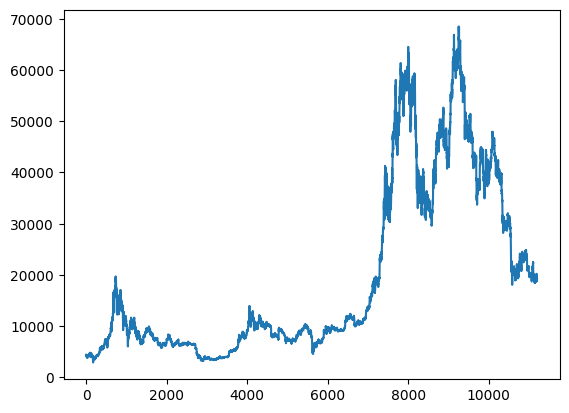

In [40]:
plt.plot(X_data_gen_train.features[:,0])
plt.show()

In [41]:
np.array(X_data_gen_train[15][0][0]).shape

(137,)

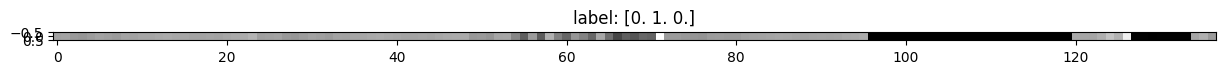

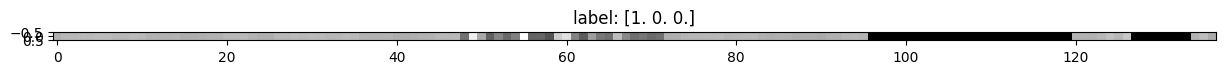

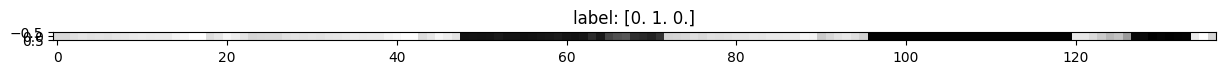

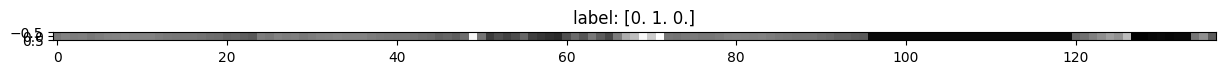

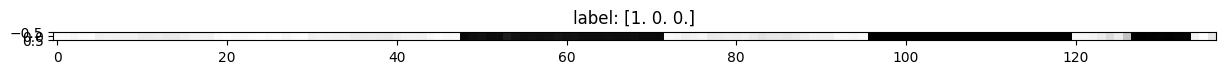

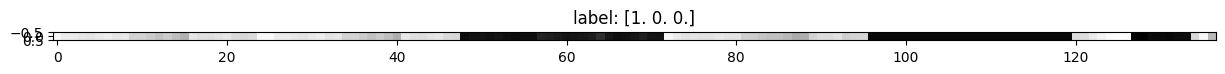

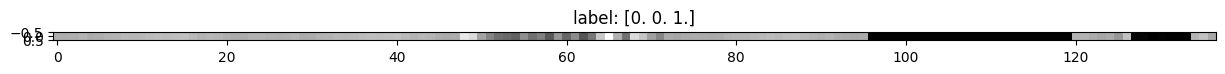

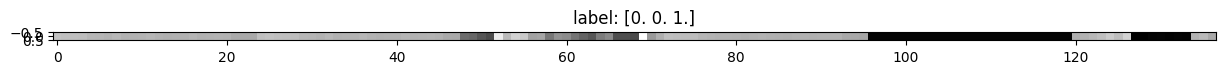

In [42]:
for idx, data_2d in enumerate(np.array(X_data_gen_train[15][0])):
    data_2d = data_2d.reshape(1,-1)
    plt.figure(figsize=(15,8))
    # Visualize the image
    plt.imshow(data_2d, cmap='gray', interpolation='nearest')
    plt.title('label: {}'.format(X_data_gen_train[15][1][idx]))

    #plt.colorbar()
    plt.show()

In [ ]:
X_data_gen_test.variations.shape

(5741,)

In [ ]:
X_data_gen_test.y_classification.shape

(5741, 3)

In [ ]:
input_data= X_data_gen_test.InputData['Close'][lookback:].values.reshape(-1,1)
input_data.shape


(5741, 1)

In [ ]:
#aux_data=np.hstack([X_data_gen_test.variations.reshape(-1,1),X_data_gen_test.features[:,0].reshape(-1,1),X_data_gen_test.y_classification])
input_data= X_data_gen_test.InputData['Close'][lookback:].values.reshape(-1,1)
aux_data=np.hstack([X_data_gen_test.variations[:].reshape(-1,1)*100, input_data, X_data_gen_test.y_classification])

#recomentations_2=pd.DataFrame(data=aux_data,columns=['var','X', 'Hold','Buy','Strong_Buy','Sell','Strong_Sell'])
recomentations_2=pd.DataFrame(data=aux_data,columns=['var','X', 'Hold','Buy','Sell'])
recomentations_2.head(20)    


var         X  Hold  Buy  Sell
0   3.634780  61762.20   0.0  1.0   0.0
1   2.034436  62730.90   0.0  1.0   0.0
2   2.451946  62490.36   0.0  1.0   0.0
3   0.983390  63003.92   1.0  0.0   0.0
4   2.074506  62721.43   0.0  1.0   0.0
5   1.398059  63019.72   1.0  0.0   0.0
6  -0.145171  64007.12   1.0  0.0   0.0
7   0.238948  63782.57   1.0  0.0   0.0
8   0.241548  63793.39   1.0  0.0   0.0
9  -0.279033  64022.59   1.0  0.0   0.0
10 -0.425720  64017.64   1.0  0.0   0.0
11 -0.265116  63840.08   1.0  0.0   0.0
12 -0.479378  63842.02   1.0  0.0   0.0
13 -2.349522  64101.11   0.0  0.0   1.0
14 -2.518865  63928.01   0.0  0.0   1.0
15 -2.447006  63880.92   0.0  0.0   1.0
16 -3.188387  63297.84   0.0  0.0   1.0
17 -4.770255  63325.75   0.0  0.0   1.0
18 -4.935569  63320.16   0.0  0.0   1.0
19 -4.297574  62898.04   0.0  0.0   1.0

In [ ]:
#recomentations_2=pd.DataFrame(data=np.hstack([np.roll(X_data_gen_train.variations.reshape(-1,1),1)[lookback:],X_data_gen_train.features[:,lookback-1].reshape(-1,1),X_data_gen_train.y_classification]),columns=['var','X', 'Hold','Buy','Sell'])
#recomentations_2.head(10)

In [ ]:
'''variations = ((X_train - np.roll(X_train, 1)) / X_train) * 100
recomendations=pd.DataFrame(data=np.hstack([np.vstack([variations[lookback:-pred_days],X_train[lookback:-pred_days]]).T,X_data_gen_train.comput_outputs(X_train)]), columns=['var','X', 'Hold','Buy','Sell'])
recomendations.head(10)'''

"variations = ((X_train - np.roll(X_train, 1)) / X_train) * 100\nrecomendations=pd.DataFrame(data=np.hstack([np.vstack([variations[lookback:-pred_days],X_train[lookback:-pred_days]]).T,X_data_gen_train.comput_outputs(X_train)]), columns=['var','X', 'Hold','Buy','Sell'])\nrecomendations.head(10)"

###  Get imbalanced database 

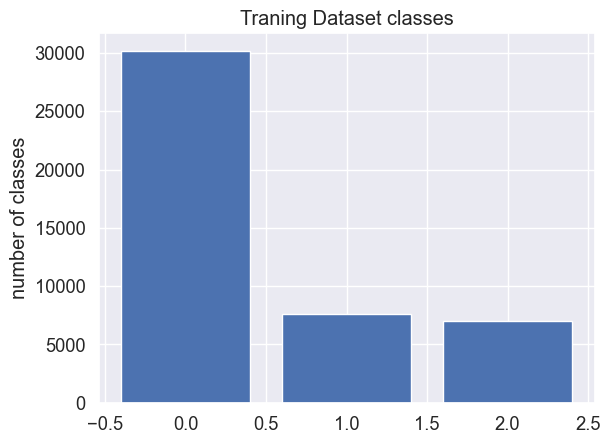

In [ ]:
Y_train_categorical=np.argmax(X_data_gen_train.y_classification,axis=1)
classes, counts=np.unique(Y_train_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Traning Dataset classes')
plt.show()

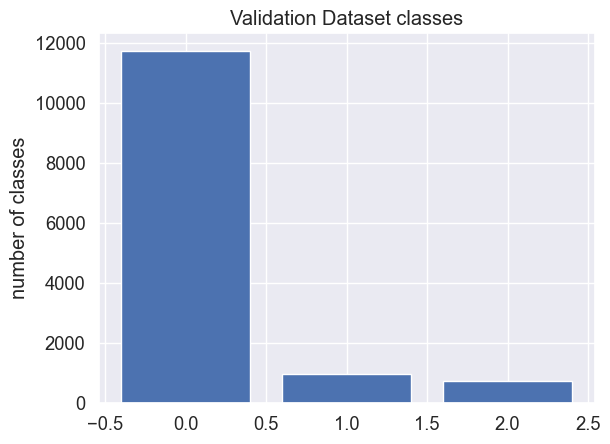

In [ ]:
Y_val_categorical=np.argmax(X_data_gen_val.y_classification,axis=1)
classes, counts=np.unique(Y_val_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Validation Dataset classes')
plt.show()

In [ ]:
n_classes=X_data_gen_train.y_classification.shape[1]

In [ ]:
from sklearn.utils import class_weight
output_class_weights = class_weight.compute_class_weight('balanced', classes=np.arange(n_classes), y=np.argmax(X_data_gen_train.y_classification,axis=1))
print(output_class_weights)
weighted_categorical_crossentropy_loss= X_data_gen_train.weighted_categorical_crossentropy(output_class_weights)

[0.4949187  1.95607946 2.13565947]


## Neural Networkt aproach

In [ ]:
X_data,y_data=X_data_gen_train[0]
n_classes=y_data.shape[1]
n_classes

3

### Models 1D

#### CNN_LSTM

In [ ]:
# Model name
model_name = "CNN_LSTM_MultiHead"
#np.random.seed(42)

# Define CNN-LSTM feature extraction function
def CNN_LSTM(inputs):
  x = Conv1D(64, kernel_size=1, strides=1, activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.2)(x)
  return x

def CNN_bracnh(Features):
    x = Conv1D(64, kernel_size=1, strides=1, activation='relu')(Features)
    x = BatchNormalization()(x)
    x = MaxPooling1D(1)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x
  
# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation, name= None):
  x = Dense(256)(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Dense(n_outputs)(x)

  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output

# Create the full model
input_shape = (X_data.shape[1], 1)  # Assuming your input shape
input_data = Input(shape=input_shape)

Features = CNN_LSTM(input_data)
#features_branch1=CNN_bracnh(Features)
features_branch2=CNN_bracnh(Features)
# Create separate heads with appropriate number of outputs and activations
#regression_output = head(features_branch1, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(features_branch2, n_outputs=n_classes, activation='softmax',name='classification_head')

# Create the model with two heads
model_CNN_LSTM = Model(inputs=input_data, outputs=[classification_output])
model_CNN_LSTM._name = model_name

# Print model summary
model_CNN_LSTM.summary()

Model: "CNN_LSTM_MultiHead"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 24, 64)            128       
                                                                 
 batch_normalization_34 (Ba  (None, 24, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 12, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 12, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 12, 64)     

In [ ]:
X_data.shape

TensorShape([8, 24])

In [ ]:
# Model name
model_name = "CNN_MultiHead"
#np.random.seed(42)

def common_layers(input1):
        """Common layers to the network model

        Returns:
            Graph: the common layers model
        """

        ##################################################################
        # CNN architecture
        conv_layer = Conv1D(64, (3), padding="same")(input1)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=1, padding="same")(conv_layer)
        conv_layer = Conv1D(128, (3), padding="same")(conv_layer)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=2, padding="same")(conv_layer)
        
        ##################################################################

        return conv_layer

def head_layer(conv_layer, num_classes, activation='linear', output_name=None):
    
    head1 = Conv1D(64, (3), padding="same")(conv_layer)
    head1 = BatchNormalization()(head1)
    head1 = Activation('relu')(head1)
    head1 = MaxPooling1D(pool_size=(3), strides=2, padding="same")(head1)

    head1 = Dropout(0.2)(head1)
    head1 = Flatten()(head1)

    x = Dense(256)(head1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(num_classes)(x)
    x = Activation(activation, name=output_name)(x)

    return x

# Create the full model
input_data = Input(shape=input_shape)

Features = common_layers(input_data)
# Create separate heads with appropriate number of outputs and activations
#regression_output = head_layer(Features, num_classes=pred_days, activation='linear',output_name='regression_head')
classification_output = head_layer(Features, num_classes=n_classes, activation='softmax',output_name='classification_head')

# Create the model with two heads
model_CNN_MultiHead = Model(inputs=input_data, outputs=[classification_output])
model_CNN_MultiHead._name = model_name

# Print model summary
model_CNN_MultiHead.summary()

Model: "CNN_MultiHead"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 24, 64)            256       
                                                                 
 batch_normalization_37 (Ba  (None, 24, 64)            256       
 tchNormalization)                                               
                                                                 
 activation_31 (Activation)  (None, 24, 64)            0         
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 24, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 24, 128)         

#### MultiLayer Perceptron

In [ ]:
# Model name
model_name = "MLP"

# Input layer
input_shape = (X_data.shape[1],)  # Assuming your input shape
input_data = Input(shape=input_shape)

# Dense layer 1 with batch normalization
x = Dense(64)(input_data)
x = BatchNormalization()(x)
activation1 = Activation('relu')(x)

#Dense layer 2 with batch normalization and dropout
x = Dense(32)(activation1)
x = BatchNormalization()(x)
activation2 = Activation('relu')(x)
x = Dropout(0.2)(activation2)


# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation='linear', name= None):
  """
  Defines a dense layer head for either regression or classification.

  Args:
      features: Input tensor from the feature extraction part.
      n_outputs: Number of outputs for the head.
      activation: Activation function for the output layer (defaults to 'linear' for regression).

  Returns:
      A Keras functional API model representing the head with its output.
  """

  x = Dense(32)(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  output = Dense(n_outputs)(x)
  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output


# Create separate heads with appropriate number of outputs and activations
#regression_output = head(activation2, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(activation2, n_outputs=n_classes, activation='softmax',name='classification_head')

# Create the model
model_MLP = Model(inputs=input_data, outputs=[classification_output])
model_MLP._name = model_name

# Print model summary
model_MLP.summary()


Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 24)]              0         
                                                                 
 dense_49 (Dense)            (None, 64)                1600      
                                                                 
 batch_normalization_42 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_43 (Ba  (None, 32)                128       
 tchNormalization)                                             

In [ ]:
model_name = "simple_MLP"
model_simple_MLP = Sequential([
    Dense(64, activation='relu', input_shape=(X_data.shape[1],)),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model_simple_MLP._name = model_name
model_simple_MLP.summary()

Model: "simple_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 64)                1600      
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 dense_55 (Dense)            (None, 3)                 99        
                                                                 
Total params: 3779 (14.76 KB)
Trainable params: 3779 (14.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Long Short-Term Memory (LSTM) 

In [ ]:
model_name= "LSTM"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=True)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

lstm_output2  = LSTM(64, activation='relu', return_sequences=False)(Dropout_output)
Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

dense_output = Dense(32, activation='relu')(Dropout_output)
Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(n_classes, activation='softmax')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 64)            16896     
                                                                 
 batch_normalization_45 (Ba  (None, 24, 64)            256       
 tchNormalization)                                               
                                                                 
 activation_39 (Activation)  (None, 24, 64)            0         
                                                                 
 dropout_30 (Dropout)        (None, 24, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                              

#### Long Short-Term Memory (GRU) 

In [ ]:
model_name= "GRU"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)
# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(n_classes, activation='softmax')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 batch_normalization_46 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_40 (Activation)  (None, 64)                0         
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 3)                 195       
                                                               

#### LSTM with Attention layer

In [ ]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="Attention_")
class Attention_(tf.keras.layers.Layer):
    def __init__(self, units,  **kwargs):
        super(Attention_, self).__init__( **kwargs)
        self.units = units
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        self.W.build(input_shape)
        self.V.build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=-1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=-1)

        return context_vector

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
model_name= "LSTM_AT"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)

# Dense layer 1 with batch normalization
x = Dense(64)(input_data)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Dense layer 2 with batch normalization and dropout
x = Dense(32)(x)
x = BatchNormalization()(x)
X = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(32)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(x)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention_(64)(X)

x = tf.keras.layers.Dense(n_classes,activation='softmax')(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 dense_59 (Dense)            (None, 24, 64)            128       
                                                                 
 batch_normalization_47 (Ba  (None, 24, 64)            256       
 tchNormalization)                                               
                                                                 
 activation_41 (Activation)  (None, 24, 64)            0         
                                                                 
 dense_60 (Dense)            (None, 24, 32)            2080      
                                                                 
 batch_normalization_48 (Ba  (None, 24, 32)            128       
 tchNormalization)                                         

### Models 2D

In [ ]:
'''
def CNN_model():
    model = Sequential()
    model.add(Conv2D (32,5,5, padding='same', input_shape=(1,5, 4), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dense (200, activation='relu'))
    model.add(Dropout (0.2))
    model.add(Flatten())
    model.add(Dense (200, activation=' relu'))
    model.add(Dense (3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model
    '''

"\ndef CNN_model():\n    model = Sequential()\n    model.add(Conv2D (32,5,5, padding='same', input_shape=(1,5, 4), activation='relu')) \n    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))\n    model.add(Dense (200, activation='relu'))\n    model.add(Dropout (0.2))\n    model.add(Flatten())\n    model.add(Dense (200, activation=' relu'))\n    model.add(Dense (3, activation='softmax'))\n    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])\n    return model\n    "

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [ ]:
from tensorflow.keras import backend as K

def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [ ]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    #optimizer1 = tf.keras.optimizers.RMSprop(learning_rate=0.05)
    return optimizer1
    #

**Train options callbacks**  

In [ ]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=20, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.01, patience = 5, min_lr=1e-20,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

In [ ]:
#ategorical_accuracy =tf.keras.metrics.categorical_accuracy
#loss =tf.keras.losses.categorical_crossentropy
loss = weighted_categorical_crossentropy_loss
#loss = tf.keras.losses.MAE

In [ ]:
#list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_CNN_MultiHead, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]
#list_of_models=[model_LSTM_AT]
#list_of_models=[model_MLP, model_CNN_LSTM, model_LSTM_AT]
list_of_models=[model_MLP]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss=[loss], optimizer=optimizer, metrics=['accuracy',matthews_correlation_coefficient])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    #history=model.fit( X_data_gen_train, validation_data=X_data_gen_val, epochs=200, batch_size=32, shuffle=False, validation_split=0.3, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])
    #history=model.fit_generator( X_data_gen_train, epochs=200, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger], validation_data=X_data_gen_val, verbose=0)
    #history=model.fit( X_data_gen_train.features, X_data_gen_train.y_classification, epochs=200, verbose=1)
    history = model.fit(
        X_data_gen_train,
        epochs=200,
        callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback, csvLogger],
        validation_data=X_data_gen_val,
        #shuffle=True,
        verbose=2
    )
    # Assuming history_metric, history_metric_val, history are defined elsewhere

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))  # Create subplots programmatically

    # Plot accuracy, sharing x-axis with NRMSE
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title(f'{model._name}: Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')  # Shared x-axis label
    axes[0].legend(['train', 'validation'], loc='upper left')

    # Plot loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title(f'{model._name}: Loss (categorical_crossentropy)')
    axes[1].set_ylabel('Loss')

    # Adjust spacing and margins (optional)
    plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.2)

    # Fine-tune spacing (optional)
    plt.tight_layout()

    plt.show()

    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

Training model : models/model_LSTM_AT_stock_BTC-USD_lookback_24
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200

Epoch 1: val_loss improved from inf to 9.17898, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_24\assets


5600/5600 - 110s - loss: 14.1369 - accuracy: 0.2975 - matthews_correlation_coefficient: -5.3783e-02 - val_loss: 9.1790 - val_accuracy: 0.0554 - val_matthews_correlation_coefficient: -4.1687e-01 - lr: 0.0500 - 110s/epoch - 20ms/step
Epoch 2/200


KeyboardInterrupt: 

### Validation

#### Load the trained models


In [ ]:
trained_best_models={}
for model in list_of_models:
    print(model.name)
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=tf.keras.models.load_model(
        checkpoint_filepath, 
        custom_objects={'loss': weighted_categorical_crossentropy_loss, 'matthews_correlation_coefficient': matthews_correlation_coefficient})

LSTM_AT



#### Using the validation Dataset

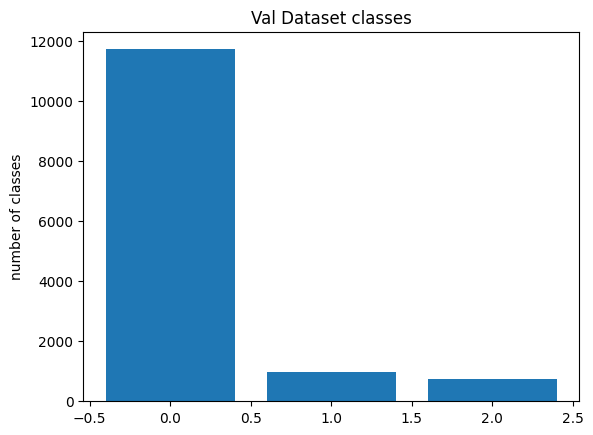

In [ ]:
Y_val_categorical=np.argmax(X_data_gen_val.y_classification,axis=1)
classes, counts=np.unique(Y_val_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Val Dataset classes')
plt.show()

In [ ]:
# get metrics on validation dataset
idxs=np.where(np.argmax(X_data_gen_val.y_classification,axis=1)>-1)[0]


import utils
for model_name in trained_best_models:

    x_data= np.apply_along_axis(lambda row: X_data_gen_val.norm_minmax(row, minimum=0, maximum=1, axis=-1), axis=1, arr=X_data_gen_val.features[idxs])

    label_pred = trained_best_models[model_name].predict(x_data)
    print(model_name,' classification Accuracy',
                    utils.f1_score(np.argmax(X_data_gen_val.y_classification[idxs],axis=1),
                    np.argmax(label_pred,axis=1), average='macro'))
#utils.model_metrics(['subida','Descida'], y_test, y_pred, Get_metrics=False)

#utils.plot_confusion_matrix(['subida','Descida'], y_test, y_pred)

420/420 [==============================] - 4s 7ms/step
LSTM_AT  classification Accuracy 0.045052553595406775


In [ ]:
np.argmax(X_data_gen_val.y_classification[idxs],axis=1).shape

(13425,)

Model name: LSTM_AT
420/420 [==============================] - 5s 11ms/step
LSTM_AT  classification Accuracy 0.045052553595406775


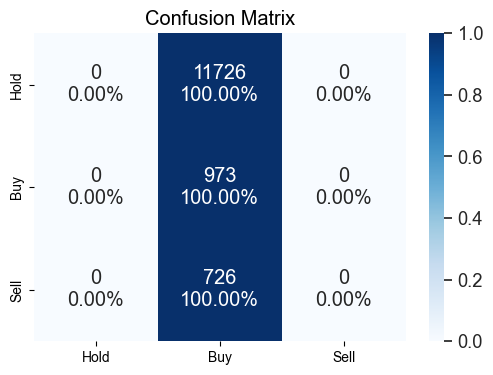

In [ ]:
model_name = "LSTM_AT"  
print('Model name:',model_name)
x_data= np.apply_along_axis(lambda row: X_data_gen_val.norm_minmax(row, minimum=0, maximum=1, axis=-1), axis=1, arr=X_data_gen_val.features[idxs])
label_pred = trained_best_models[model_name].predict(x_data)
print(model_name,' classification Accuracy',
                utils.f1_score(np.argmax(X_data_gen_val.y_classification[idxs],axis=1),
                np.argmax(label_pred,axis=1),average="macro"))

cf_matrix = utils.confusion_matrix(np.argmax(X_data_gen_val.y_classification[idxs],axis=1),np.argmax(label_pred,axis=1))
 
try:
    utils.plot_confusion_matrix(gesture_list= ['Hold','Buy','Sell'], cf_matrix=cf_matrix)
except:
    print(cf_matrix)

### Using test dataset

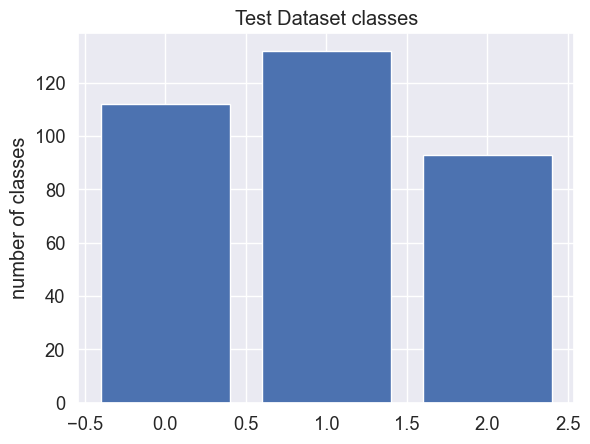

In [ ]:
Y_train_categorical=np.argmax(X_data_gen_test.y_classification,axis=1)
classes, counts=np.unique(Y_train_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Test Dataset classes')
plt.show()

In [ ]:
X_data_gen_test = FeaturesDataGenerator(df[df['Date'].isin(T_test)].iloc[:,1:], lookback = lookback, pred_days = pred_days, shuffle= False, batch_size=1, selected_features = features_indicators, data_augmentation=False)
test_data=[]
targets=[]
for X,y in X_data_gen_test:
    #train_data+=[scaler.transform(np.array(X).reshape(-1,1))]
    test_data+=[np.array(X)]
    targets+=[np.argmax(y)]
targets = np.stack(targets)
test_data = np.vstack(test_data)

self.pred_days 7
input data shape (337, 10)
output data shape (337, 3)


In [ ]:
# get metrics for all deep learning models 
import utils
for model_name in trained_best_models:
    label_pred = trained_best_models[model_name].predict(test_data)
    print(f'{model_name} metrics:')
    utils.model_average_std_metrics(targets, np.argmax(label_pred,axis=1), Get_metrics= True,  Verbose=True) ;
    print('------------------------------------------------')

11/11 [==============================] - 0s 4ms/step
MLP metrics:
Precision Score: nan±nan
Recall Score: 0.3257±0.2338
F1-Score: nan±nan
Accuracy: 0.3257±0.2338
------------------------------------------------


d:\Projetos_python\Time_Series_Forecast\acoes\utils.py:97: RuntimeWarning:

invalid value encountered in divide



11/11 [==============================] - 0s 5ms/step
CNN_LSTM_MultiHead metrics:
Precision Score: 0.3313±0.0404
Recall Score: 0.3342±0.1653
F1-Score: 0.3025±0.0571
Accuracy: 0.3342±0.1653
------------------------------------------------
11/11 [==============================] - 0s 5ms/step
LSTM_AT metrics:
Precision Score: nan±nan
Recall Score: 0.3333±0.4714
F1-Score: nan±nan
Accuracy: 0.3333±0.4714
------------------------------------------------


d:\Projetos_python\Time_Series_Forecast\acoes\utils.py:97: RuntimeWarning:

invalid value encountered in divide



Model name: MLP
11/11 [==============================] - 0s 3ms/step
MLP  classification Accuracy 0.25647764240607257


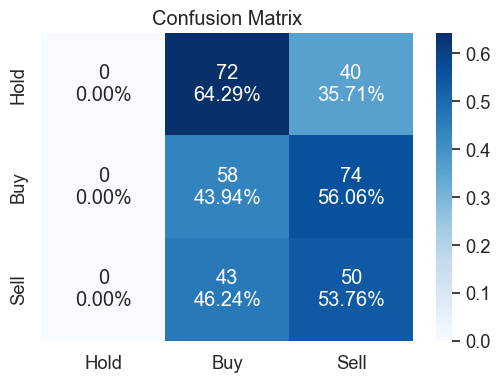

In [ ]:
model_name = "MLP"  
print('Model name:',model_name)

label_pred = trained_best_models[model_name].predict(test_data)
print(model_name,' classification Accuracy',utils.f1_score(targets, np.argmax(label_pred,axis=1),average='macro'))

cf_matrix = utils.confusion_matrix(targets,np.argmax(label_pred,axis=1))
 
try:
    utils.plot_confusion_matrix(gesture_list= ['Hold','Buy','Sell'], cf_matrix=cf_matrix)
except:
    print(cf_matrix)

#### Using Machine Learning models to Predicti next recomendations

In [ ]:
df[df['Date'].isin(T_test)].iloc[:,1:].values.shape

(338, 26)

In [ ]:
X_data_gen_test.y_classification.shape
X_data_gen_test.comput_outputs(df[df['Date'].isin(T_test)].iloc[:,1]).shape

(323, 3)

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define ML models and their names
ML_models = {
    'SVM': SVC(kernel='linear',decision_function_shape='ovr'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost RF': xgb.XGBRFClassifier(n_estimators=100)
}

x_data_train= np.apply_along_axis(lambda row: X_data_gen_train.norm_minmax(row, minimum=0, maximum=1, axis=-1), axis=1, arr=X_data_gen_train.features)
x_data_val= np.apply_along_axis(lambda row: X_data_gen_val.norm_minmax(row, minimum=0, maximum=1, axis=-1), axis=1, arr=X_data_gen_val.features)
x_data_test= np.apply_along_axis(lambda row: X_data_gen_test.norm_minmax(row, minimum=0, maximum=1, axis=-1), axis=1, arr=X_data_gen_test.features)


# Iterate over ML models
for name, model in ML_models.items():
    # Train the model
    model.fit(x_data_train, np.argmax(X_data_gen_train.y_classification, axis=1) )

    # Make predictions on datasets
    train_pred = model.predict(x_data_train)
    val_pred = model.predict(x_data_val)
    test_pred = model.predict(x_data_test)

    # Calculate accuracy on datasets
    train_accuracy = accuracy_score(np.argmax(X_data_gen_train.y_classification, axis=1), train_pred)
    val_accuracy = accuracy_score(np.argmax(X_data_gen_val.y_classification, axis=1), val_pred)
    #test_accuracy = accuracy_score(np.argmax(X_data_gen_test.comput_outputs(df[df['Date'].isin(T_test)].iloc[:,1].values), axis=1), test_pred)
    test_accuracy = accuracy_score(np.argmax(X_data_gen_test.y_classification, axis=1), test_pred)

    # Print results
    print('-------------------------------------------------------------')
    print(f'{name} - Train Classification Accuracy: {train_accuracy}')
    print(f'{name} - Validation Classification Accuracy: {val_accuracy}')
    print(f'{name} - Test Classification Accuracy: {test_accuracy}')


-------------------------------------------------------------
SVM - Train Classification Accuracy: 0.4624226348364279
SVM - Validation Classification Accuracy: 0.3295774647887324
SVM - Test Classification Accuracy: 0.3056379821958457
-------------------------------------------------------------
Decision Tree - Train Classification Accuracy: 1.0
Decision Tree - Validation Classification Accuracy: 0.41784037558685444
Decision Tree - Test Classification Accuracy: 0.3590504451038576
-------------------------------------------------------------
Random Forest - Train Classification Accuracy: 1.0
Random Forest - Validation Classification Accuracy: 0.40751173708920185
Random Forest - Test Classification Accuracy: 0.3086053412462908


d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



-------------------------------------------------------------
Logistic Regression - Train Classification Accuracy: 0.46035956380783966
Logistic Regression - Validation Classification Accuracy: 0.323943661971831
Logistic Regression - Test Classification Accuracy: 0.3323442136498516
-------------------------------------------------------------
K-Nearest Neighbors - Train Classification Accuracy: 0.8983200707338639
K-Nearest Neighbors - Validation Classification Accuracy: 0.355868544600939
K-Nearest Neighbors - Test Classification Accuracy: 0.34718100890207715
-------------------------------------------------------------
XGBoost RF - Train Classification Accuracy: 0.7335691128794577
XGBoost RF - Validation Classification Accuracy: 0.38967136150234744
XGBoost RF - Test Classification Accuracy: 0.33827893175074186


Model name: Decision Tree
Decision Tree  classification Accuracy 0.35701393329542924


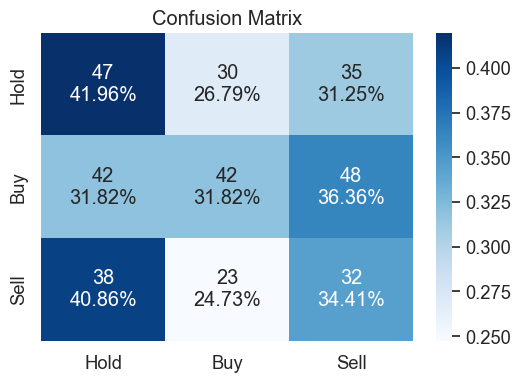

In [ ]:
model_name = "Decision Tree"  
print('Model name:',model_name)

label_pred = ML_models[model_name].predict(test_data)

print(model_name,' classification Accuracy',utils.f1_score(targets, label_pred, average='macro'))

cf_matrix = utils.confusion_matrix(targets,label_pred)
 
try:
    utils.plot_confusion_matrix(gesture_list= ['Hold','Buy','Sell'], cf_matrix=cf_matrix)
except:
    print(cf_matrix)

### Get new values to future prediction 

In [ ]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-12-11
Estamos Fornecendo dados até o dia : 2024-12-10
O modelo fará previsões até o dia:  2024-12-17


In [ ]:
data_inference=df[df['Date'].isin(T_test.iloc[-lookback-3:])].iloc[:,1:]
#data_inference=df[df['Date'].isin(T_test.iloc[:])].iloc[:,1:]
data_inference.shape


(4, 26)

In [ ]:
data_inference.shape

(4, 26)

In [ ]:
dataGen_inference = FeaturesDataGenerator(data_inference, lookback = lookback, pred_days = pred_days, shuffle= False, batch_size=1, selected_features = features_indicators, data_augmentation=False)

self.pred_days 7
input data shape (3, 10)
output data shape (3, 3)


In [ ]:
data_inference['Close'][-lookback:].shape

(1,)

In [ ]:
trade=['Hold','Buy','Sell']

In [ ]:
pred_days

7

In [ ]:
data_inference=df[df['Date'].isin(T_test.iloc[-lookback-pred_days-3:])].iloc[:,1:]
data_inference['Close'].values.astype(np.float32).shape

(11,)

In [ ]:
data_inference['Close'].values

array([ 97279.7890625,  95865.3046875,  96002.1640625,  98768.53125  ,
        96593.5703125,  99920.7109375,  99923.3359375, 101236.015625 ,
        97432.71875  ,  96675.4296875,  98920.875    ])

In [ ]:
dataGen_inference.comput_features(data_inference, pred_days=1)

array([[9.58653047e+04, 2.50093422e+01, 9.81135703e+04, 9.80562266e+04,
        9.80562266e+04, 9.80562266e+04, 9.80562266e+04, 9.65725469e+04,
        9.65725469e+04, 0.00000000e+00],
       [9.60021641e+04, 2.49289703e+01, 9.81135703e+04, 9.80562266e+04,
        9.80562266e+04, 9.80562266e+04, 9.80562266e+04, 9.63824141e+04,
        9.63824141e+04, 0.00000000e+00],
       [9.87685312e+04, 2.50696621e+01, 9.81135703e+04, 9.80562266e+04,
        9.80562266e+04, 9.80562266e+04, 9.80562266e+04, 9.69789453e+04,
        9.69789453e+04, 0.00000000e+00],
       [9.65935703e+04, 2.57286797e+01, 9.81135703e+04, 9.80562266e+04,
        9.80562266e+04, 9.80562266e+04, 9.80562266e+04, 9.69018672e+04,
        9.69018672e+04, 0.00000000e+00],
       [9.99207109e+04, 2.52722340e+01, 9.81135703e+04, 9.80562266e+04,
        9.80562266e+04, 9.80562266e+04, 9.80562266e+04, 9.74050078e+04,
        9.74050078e+04, 0.00000000e+00],
       [9.99233359e+04, 2.45114822e+01, 9.81135703e+04, 9.80562266e+04,
   

In [ ]:
x_data_inference=dataGen_inference.comput_features(data_inference, pred_days=0)

model_name='MLP'
label_pred = trained_best_models[model_name].predict(x_data_inference)
trade[np.argmax(label_pred[-1])]

1/1 [==============================] - 0s 54ms/step


'Sell'